In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from IPython.display import display
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.formula.api import ols
from scipy.stats import ttest_ind, chi2_contingency

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
input=pd.read_csv(r'C:\Users\User\Downloads/EEG.machinelearing_data_BRMH.csv')

In [4]:
# Identify unnamed columns
unnamed_columns = [col for col in input.columns if 'Unnamed' in col]
if not unnamed_columns:
    print("No unnamed columns found.")
else:
    print("Unnamed columns:", unnamed_columns)
    print(" Dropping it.")

# Check if unnamed columns are empty
empty_unnamed_columns = [col for col in unnamed_columns if input[col].isnull().all()]

# Drop empty unnamed columns
input.drop(empty_unnamed_columns, axis=1, inplace=True)

unnamed_columns = [col for col in input.columns if 'Unnamed' in col]
if not unnamed_columns:
    print("No unnamed columns found.")
else:
    print("Unnamed columns:", unnamed_columns)

Unnamed columns: ['Unnamed: 122']
 Dropping it.
No unnamed columns found.


In [5]:
input.head()

,no.,sex,age,eeg.date,education,IQ,main.disorder,specific.disorder,AB.A.delta.a.FP1,AB.A.delta.b.FP2,...,COH.F.gamma.o.Pz.p.P4,COH.F.gamma.o.Pz.q.T6,COH.F.gamma.o.Pz.r.O1,COH.F.gamma.o.Pz.s.O2,COH.F.gamma.p.P4.q.T6,COH.F.gamma.p.P4.r.O1,COH.F.gamma.p.P4.s.O2,COH.F.gamma.q.T6.r.O1,COH.F.gamma.q.T6.s.O2,COH.F.gamma.r.O1.s.O2
0,1,M,57.0,2012.8.30,NaN,NaN,Addictive disorder,Alcohol use disorder,35.998557,21.717375,...,55.989192,16.739679,23.452271,45.678820,30.167520,16.918761,48.850427,9.422630,34.507082,28.613029
1,2,M,37.0,2012.9.6,6.0,120.0,Addictive disorder,Alcohol use disorder,13.425118,11.002916,...,45.595619,17.510824,26.777368,28.201062,57.108861,32.375401,60.351749,13.900981,57.831848,43.463261
2,3,M,32.0,2012.9.10,16.0,113.0,Addictive disorder,Alcohol use disorder,29.941780,27.544684,...,99.475453,70.654171,39.131547,69.920996,71.063644,38.534505,69.908764,27.180532,64.803155,31.485799
3,4,M,35.0,2012.10.8,18.0,126.0,Addictive disorder,Alcohol use disorder,21.496226,21.846832,...,59.986561,63.822201,36.478254,47.117006,84.658376,24.724096,50.299349,35.319695,79.822944,41.141873
4,5,M,36.0,2012.10.18,16.0,112.0,Addictive disorder,Alcohol use disorder,37.775667,33.607679,...,61.462720,59.166097,51.465531,58.635415,80.685608,62.138436,75.888749,61.003944,87.455509,70.531662


In [6]:
input.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 945 entries, 0 to 944
Columns: 1148 entries, no. to COH.F.gamma.r.O1.s.O2
dtypes: float64(1143), int64(1), object(4)
memory usage: 8.3+ MB


In [7]:
columns_of_interest = input.columns  # Adjust column indices as needed

nan_counts_specific = input[columns_of_interest].isna().sum()
nan_counts_specific = nan_counts_specific[nan_counts_specific != 0]

if not nan_counts_specific.empty:
    print("NaN counts for specified columns:")
    print(nan_counts_specific)
else:
    print("No NaN values found in specified columns.")

NaN counts for specified columns:
education    15
IQ           13
dtype: int64


In [8]:
columns_of_interest = ['sex','education','IQ','main.disorder','specific.disorder']
# Count unique values in specified columns
unique_value_counts = input[columns_of_interest].nunique()

# Display unique value counts for specified columns
print("Unique value counts in specified columns:")
print(unique_value_counts)

Unique value counts in specified columns:
sex                   2
education            19
IQ                   87
main.disorder         7
specific.disorder    12
dtype: int64


In [9]:
# Identify columns with NaN values
columns_with_nan = nan_counts_specific.index.tolist()

# Drop rows where any of the specified columns have NaN values
input.dropna(subset=columns_with_nan, inplace=True)

# Confirm that rows with NaN values in specified columns are dropped
print("After dropping rows with NaN values:")
print(input.shape)  # Check the shape of the DataFrame after dropping rows

columns_of_interest = input.columns  # Adjust column indices as needed

nan_counts_specific = input[columns_of_interest].isna().sum()
nan_counts_specific = nan_counts_specific[nan_counts_specific != 0]

if not nan_counts_specific.empty:
    print("NaN counts for specified columns:")
    print(nan_counts_specific)
else:
    print("No NaN values found in specified columns.")

After dropping rows with NaN values:
(919, 1148)
No NaN values found in specified columns.


In [10]:
# Check the unique values in each column
for column in input.columns[1:8]:
    unique_values = sorted(input[column].unique())
    print(f"Column '{column}' has {len(unique_values)} unique values: {unique_values}")

Column 'sex' has 2 unique values: ['F', 'M']
Column 'age' has 647 unique values: [18.0, 18.07, 18.18, 18.19, 18.24, 18.34, 18.39, 18.41, 18.42, 18.44, 18.5, 18.54, 18.59, 18.68, 18.69, 18.72, 18.73, 18.77, 18.78, 18.87, 18.88, 18.89, 18.9, 18.93, 18.94, 18.96, 19.0, 19.02, 19.06, 19.08, 19.14, 19.15, 19.17, 19.19, 19.2, 19.21, 19.22, 19.23, 19.25, 19.29, 19.31, 19.35, 19.36, 19.37, 19.38, 19.4, 19.41, 19.42, 19.44, 19.46, 19.48, 19.51, 19.53, 19.54, 19.61, 19.64, 19.66, 19.68, 19.7, 19.71, 19.73, 19.74, 19.77, 19.78, 19.84, 19.85, 19.87, 19.88, 19.89, 19.91, 19.93, 19.94, 19.95, 19.96, 19.97, 20.0, 20.05, 20.06, 20.07, 20.08, 20.1, 20.11, 20.13, 20.15, 20.16, 20.17, 20.18, 20.19, 20.23, 20.24, 20.27, 20.28, 20.31, 20.36, 20.4, 20.41, 20.46, 20.48, 20.5, 20.52, 20.55, 20.57, 20.6, 20.65, 20.67, 20.68, 20.69, 20.73, 20.76, 20.77, 20.8, 20.87, 20.88, 20.89, 20.9, 20.95, 20.97, 20.98, 21.0, 21.03, 21.05, 21.06, 21.07, 21.08, 21.14, 21.15, 21.22, 21.24, 21.25, 21.26, 21.29, 21.31, 21.35, 21

In [11]:
input.drop(columns=['eeg.date'], inplace=True)

In [12]:
input.describe()

,no.,age,education,IQ,AB.A.delta.a.FP1,AB.A.delta.b.FP2,AB.A.delta.c.F7,AB.A.delta.d.F3,AB.A.delta.e.Fz,AB.A.delta.f.F4,...,COH.F.gamma.o.Pz.p.P4,COH.F.gamma.o.Pz.q.T6,COH.F.gamma.o.Pz.r.O1,COH.F.gamma.o.Pz.s.O2,COH.F.gamma.p.P4.q.T6,COH.F.gamma.p.P4.r.O1,COH.F.gamma.p.P4.s.O2,COH.F.gamma.q.T6.r.O1,COH.F.gamma.q.T6.s.O2,COH.F.gamma.r.O1.s.O2
count,919.000000,919.000000,919.000000,919.000000,919.000000,919.000000,919.000000,919.000000,919.000000,919.000000,...,919.000000,919.000000,919.000000,919.000000,919.000000,919.000000,919.000000,919.000000,919.000000,919.000000
mean,479.710555,30.631850,13.443961,101.520131,20.220673,21.238662,17.842093,18.925629,20.451592,19.505537,...,75.895626,55.057672,56.880152,60.622141,69.889681,47.782752,66.750528,39.235988,66.094264,56.933558
std,271.145663,11.801693,2.556308,17.031157,11.372461,12.348722,10.084667,9.134357,9.807305,9.295489,...,15.815383,19.505953,18.225074,18.060825,17.704717,19.566560,17.047160,20.675547,18.100158,19.516664
min,2.000000,18.000000,0.000000,49.000000,3.272260,3.244199,3.050507,3.412618,5.066593,4.048931,...,12.611954,0.519048,6.926792,0.708008,2.421748,0.036664,1.032207,1.228502,0.363268,3.988805
25%,245.500000,21.805000,12.000000,91.000000,12.812690,13.032435,11.157449,12.464049,13.531989,12.690113,...,68.049966,41.641266,43.701438,48.362521,59.001486,32.604240,55.862451,22.104332,54.695239,43.908411
50%,484.000000,26.170000,13.000000,102.000000,17.036455,17.776402,15.571381,16.634008,18.022553,17.432568,...,78.647712,55.296428,56.541607,61.160337,72.393403,45.695172,68.238375,36.549938,67.985045,57.256823
75%,713.500000,35.495000,16.000000,114.000000,24.446362,25.899411,21.773978,23.331895,25.679216,23.952932,...,87.328315,69.724576,70.538246,73.954954,83.214723,61.896512,79.134352,54.112441,79.501972,71.333099
max,945.000000,71.880000,20.000000,145.000000,92.826192,101.515687,91.373456,82.544167,101.566662,77.197502,...,99.678649,100.000000,99.307895,100.000000,99.581629,98.720067,99.650154,98.413320,100.000000,99.287092


In [13]:
from sklearn.preprocessing import LabelEncoder

# Encode categorical columns and store mappings
label_encoders = {}
mappings = {}
columns=['sex','main.disorder','specific.disorder']
for column in columns:
    le = LabelEncoder()
    input[column] = le.fit_transform(input[column])
    label_encoders[column] = le
    mappings[column] = dict(zip(le.classes_, le.transform(le.classes_)))

# Check the unique values in each column and their mappings
for column in columns:
    unique_values = sorted(input[column].unique())
    print(f"Column '{column}' has {len(unique_values)} unique values: {unique_values}")
    print(f"Mappings: {mappings[column]}")

# Display the encoded data
#print(input)

Column 'sex' has 2 unique values: [0, 1]
Mappings: {'F': 0, 'M': 1}
Column 'main.disorder' has 7 unique values: [0, 1, 2, 3, 4, 5, 6]
Mappings: {'Addictive disorder': 0, 'Anxiety disorder': 1, 'Healthy control': 2, 'Mood disorder': 3, 'Obsessive compulsive disorder': 4, 'Schizophrenia': 5, 'Trauma and stress related disorder': 6}
Column 'specific.disorder' has 12 unique values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Mappings: {'Acute stress disorder': 0, 'Adjustment disorder': 1, 'Alcohol use disorder': 2, 'Behavioral addiction disorder': 3, 'Bipolar disorder': 4, 'Depressive disorder': 5, 'Healthy control': 6, 'Obsessive compulsitve disorder': 7, 'Panic disorder': 8, 'Posttraumatic stress disorder': 9, 'Schizophrenia': 10, 'Social anxiety disorder': 11}


In [14]:
input.describe()

,no.,sex,age,education,IQ,main.disorder,specific.disorder,AB.A.delta.a.FP1,AB.A.delta.b.FP2,AB.A.delta.c.F7,...,COH.F.gamma.o.Pz.p.P4,COH.F.gamma.o.Pz.q.T6,COH.F.gamma.o.Pz.r.O1,COH.F.gamma.o.Pz.s.O2,COH.F.gamma.p.P4.q.T6,COH.F.gamma.p.P4.r.O1,COH.F.gamma.p.P4.s.O2,COH.F.gamma.q.T6.r.O1,COH.F.gamma.q.T6.s.O2,COH.F.gamma.r.O1.s.O2
count,919.000000,919.000000,919.000000,919.000000,919.000000,919.000000,919.000000,919.000000,919.000000,919.000000,...,919.000000,919.000000,919.000000,919.000000,919.000000,919.000000,919.000000,919.000000,919.000000,919.000000
mean,479.710555,0.634385,30.631850,13.443961,101.520131,2.786725,5.643090,20.220673,21.238662,17.842093,...,75.895626,55.057672,56.880152,60.622141,69.889681,47.782752,66.750528,39.235988,66.094264,56.933558
std,271.145663,0.481864,11.801693,2.556308,17.031157,2.005493,3.050935,11.372461,12.348722,10.084667,...,15.815383,19.505953,18.225074,18.060825,17.704717,19.566560,17.047160,20.675547,18.100158,19.516664
min,2.000000,0.000000,18.000000,0.000000,49.000000,0.000000,0.000000,3.272260,3.244199,3.050507,...,12.611954,0.519048,6.926792,0.708008,2.421748,0.036664,1.032207,1.228502,0.363268,3.988805
25%,245.500000,0.000000,21.805000,12.000000,91.000000,1.000000,3.000000,12.812690,13.032435,11.157449,...,68.049966,41.641266,43.701438,48.362521,59.001486,32.604240,55.862451,22.104332,54.695239,43.908411
50%,484.000000,1.000000,26.170000,13.000000,102.000000,3.000000,5.000000,17.036455,17.776402,15.571381,...,78.647712,55.296428,56.541607,61.160337,72.393403,45.695172,68.238375,36.549938,67.985045,57.256823
75%,713.500000,1.000000,35.495000,16.000000,114.000000,5.000000,8.000000,24.446362,25.899411,21.773978,...,87.328315,69.724576,70.538246,73.954954,83.214723,61.896512,79.134352,54.112441,79.501972,71.333099
max,945.000000,1.000000,71.880000,20.000000,145.000000,6.000000,11.000000,92.826192,101.515687,91.373456,...,99.678649,100.000000,99.307895,100.000000,99.581629,98.720067,99.650154,98.413320,100.000000,99.287092


In [15]:
input_copy=input.copy().iloc[:, np.r_[1:6]]

corr_matrix = input_copy.corr()
display(corr_matrix)

,sex,age,education,IQ,main.disorder
sex,1.000000,-0.141354,-0.075902,0.092751,-0.297205
age,-0.141354,1.000000,-0.165761,0.023495,0.164089
education,-0.075902,-0.165761,1.000000,0.362670,-0.007646
IQ,0.092751,0.023495,0.362670,1.000000,-0.171808
main.disorder,-0.297205,0.164089,-0.007646,-0.171808,1.000000


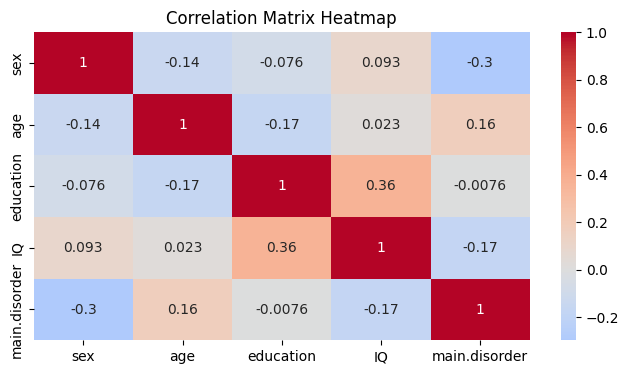

In [16]:
plt.figure(figsize=(8, 4))  # Set the size of the plot
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [17]:
from statsmodels.stats.multitest import multipletests
from scipy.stats import pearsonr
import networkx as nx

data=input_copy
#Calculate correlation matrix and p-values
correlations = data.corr()
p_values = np.zeros_like(correlations)

for i in range(data.shape[1]):
    for j in range(data.shape[1]):
        if i != j:
            _, p_values[i, j] = pearsonr(data.iloc[:, i], data.iloc[:, j])

# Apply Benjamini-Hochberg correction for multiple comparisons
p_values_flat = p_values.flatten()
_, corrected_p_values_flat, _, _ = multipletests(p_values_flat, method='fdr_bh')
corrected_p_values = corrected_p_values_flat.reshape(p_values.shape)

# Apply thresholds (r >= 0.25 and p < 0.05)
significant_edges = np.where((np.abs(correlations) >= 0.15) & (corrected_p_values < 0.05), correlations, 0)

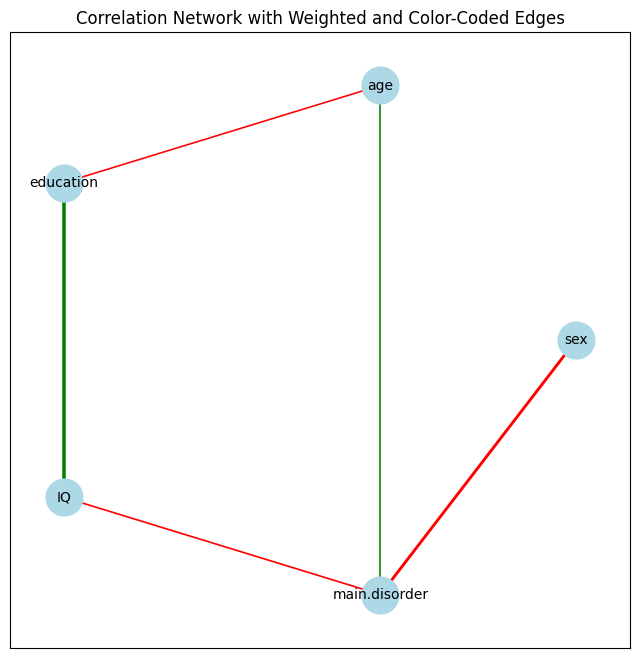

In [18]:
# Create an undirected graph
G = nx.Graph()

# Add nodes (symptoms)
for col in data.columns:
    G.add_node(col)

# Add edges for significant correlations with edge weights
for i in range(len(data.columns)):
    for j in range(i + 1, len(data.columns)):  # Avoid duplicate edges
        if significant_edges[i, j] != 0:
            # Determine edge color based on the sign of correlation
            color = 'green' if significant_edges[i, j] > 0 else 'red'
            G.add_edge(data.columns[i], data.columns[j], weight=significant_edges[i, j], color=color)

# Extract edges and colors
edges = G.edges(data=True)
weights = [d['weight'] for (u, v, d) in edges]
colors = [d['color'] for (u, v, d) in edges]

# Normalize weights for edge width
norm_weights = [abs(w) for w in weights]

# Position nodes with a spring layout
pos = nx.circular_layout(G)

# Plot the graph
plt.figure(figsize=(8, 8))

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=700)

# Draw edges with color coding based on weights
nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color=colors, width=[w*7 for w in norm_weights])

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=10, font_color="black")

plt.title('Correlation Network with Weighted and Color-Coded Edges')

# Show the plot
plt.show()

Maximal Cliques:  [['education', 'age'], ['education', 'IQ'], ['main.disorder', 'sex'], ['main.disorder', 'age'], ['main.disorder', 'IQ']]
Maximum Clique:  ['education', 'age']


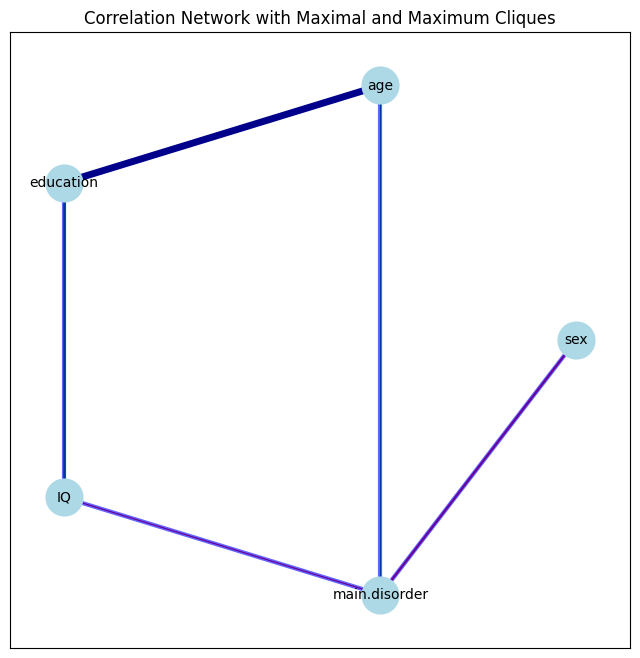

In [19]:
import networkx as nx
from networkx.algorithms.clique import find_cliques
from networkx.algorithms.approximation import clique

### Identifying Cliques

# Identify all maximal cliques
cliques = list(find_cliques(G))

# Find the largest maximal clique (i.e., the maximum clique)
maximum_clique = max(cliques, key=len)

print("Maximal Cliques: ", cliques)
print("Maximum Clique: ", maximum_clique)

### Visualize Cliques

# Create a new plot to visualize the cliques
plt.figure(figsize=(8, 8))

# Draw the base network again
nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=700)
nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color=colors, width=[w*5 for w in norm_weights])
nx.draw_networkx_labels(G, pos, font_size=10, font_color="black")

# Highlight maximal cliques (all cliques) with blue edges
for clique in cliques:
    clique_edges = [(clique[i], clique[j]) for i in range(len(clique)) for j in range(i + 1, len(clique))]
    nx.draw_networkx_edges(G, pos, edgelist=clique_edges, edge_color='blue', width=3, alpha=0.6)

# Highlight the maximum clique with darker blue edges
max_clique_edges = [(maximum_clique[i], maximum_clique[j]) for i in range(len(maximum_clique)) for j in range(i + 1, len(maximum_clique))]
nx.draw_networkx_edges(G, pos, edgelist=max_clique_edges, edge_color='darkblue', width=5, alpha=1.0)

plt.title('Correlation Network with Maximal and Maximum Cliques')

# Show the plot
plt.show()

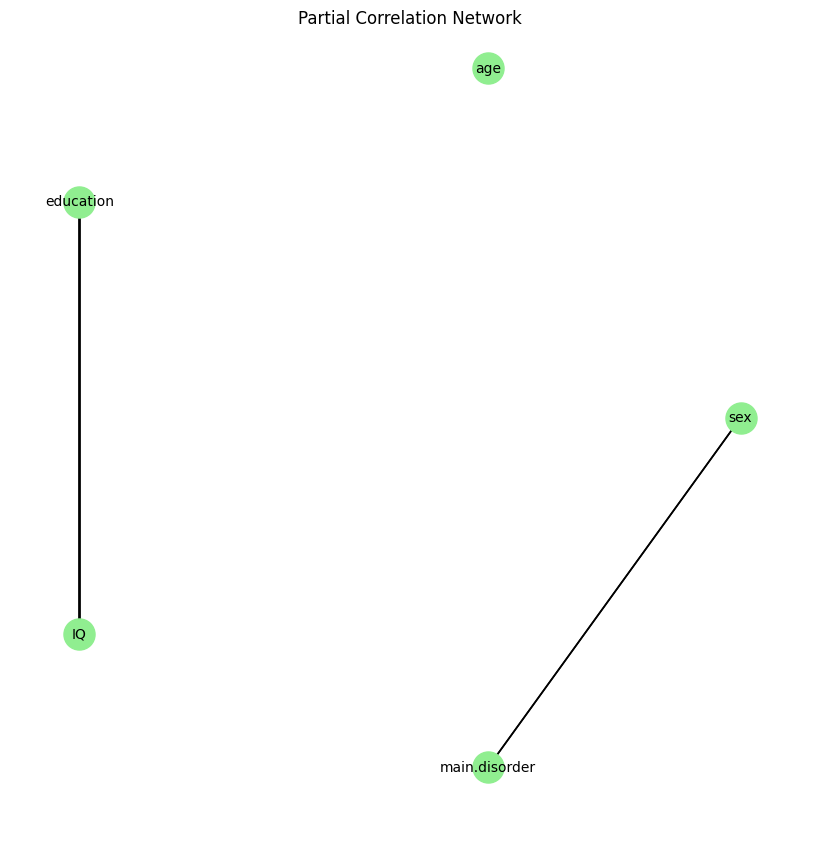

In [20]:
from sklearn.covariance import GraphicalLassoCV

# Fit a Graphical Lasso model to estimate partial correlations
model = GraphicalLassoCV()
model.fit(data)

# Extract the partial correlation matrix
partial_corr_matrix = -model.precision_ / np.sqrt(np.outer(np.diag(model.precision_), np.diag(model.precision_)))

# Create a graph for partial correlations
G_partial = nx.Graph()

# Add nodes (variables)
for col in data.columns:
    G_partial.add_node(col)

# Add edges (partial correlations) only if significant
for i, col1 in enumerate(data.columns):
    for j, col2 in enumerate(data.columns):
        if i != j and abs(partial_corr_matrix[i, j]) >= 0.25:
            G_partial.add_edge(col1, col2, weight=partial_corr_matrix[i, j])

# Plot the partial correlation network
plt.figure(figsize=(8, 8))
pos = nx.circular_layout(G_partial)
edges = G_partial.edges(data=True)

nx.draw(G_partial, pos, with_labels=True, node_size=500, node_color='lightgreen', font_size=10)
nx.draw_networkx_edges(G_partial, pos, edgelist=edges, width=[abs(d['weight'])*5 for (u, v, d) in edges])

plt.title('Partial Correlation Network')
plt.show()


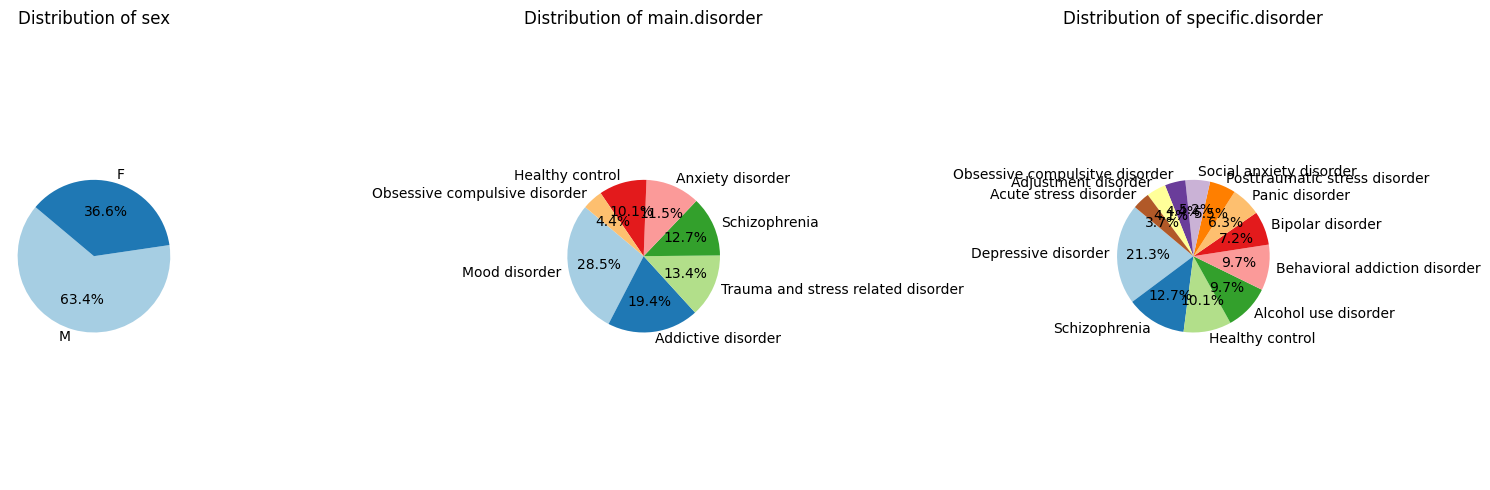

In [21]:
# Function to create pie charts
def create_pie_chart(ax, column_name, data, mappings):
    counts = data[column_name].value_counts()
    labels = [list(mappings[column_name].keys())[list(mappings[column_name].values()).index(i)] for i in counts.index]
    ax.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
    ax.set_title(f'Distribution of {column_name}')
    ax.axis('equal')

#columns we want to work on
columns_to_plot = ['sex', 'main.disorder', 'specific.disorder']
# Number of columns for the subplot grid
num_columns = 3
num_plots = len(columns_to_plot)

# Calculate number of rows needed
num_rows = (num_plots + num_columns - 1) // num_columns

fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, num_rows * 5))

# Flatten axes array if there's more than one row
if num_rows > 1:
    axes = axes.flatten()

# Create pie charts for each categorical variable
for i, column in enumerate(columns_to_plot):
    create_pie_chart(axes[i], column, input, mappings)

# Remove any unused subplots
for i in range(num_plots, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

In [22]:
# Decoding the columns back to original values
decoded_data = input.copy()
for column in columns:
    le = label_encoders[column]
    decoded_data[column] = input[column].map({v: k for k, v in mappings[column].items()})

# Group by 'main.disorder' and list unique 'specific.disorder' for each group
main_to_specific = decoded_data.groupby('main.disorder')['specific.disorder'].unique()

# Convert the result to a dictionary for easier inspection
main_to_specific_dict = main_to_specific.to_dict()

print(main_to_specific_dict)

{'Addictive disorder': array(['Alcohol use disorder', 'Behavioral addiction disorder'],
      dtype=object), 'Anxiety disorder': array(['Panic disorder', 'Social anxiety disorder'], dtype=object), 'Healthy control': array(['Healthy control'], dtype=object), 'Mood disorder': array(['Depressive disorder', 'Bipolar disorder'], dtype=object), 'Obsessive compulsive disorder': array(['Obsessive compulsitve disorder'], dtype=object), 'Schizophrenia': array(['Schizophrenia'], dtype=object), 'Trauma and stress related disorder': array(['Acute stress disorder', 'Posttraumatic stress disorder',
       'Adjustment disorder'], dtype=object)}


In [23]:
# Create mappings from your label encoders (example mappings provided)
mappings = {
    'main.disorder': {
        'Addictive disorder': 0, 'Anxiety disorder': 1, 'Healthy control': 2,
        'Mood disorder': 3, 'Obsessive compulsive disorder': 4, 'Schizophrenia': 5,
        'Trauma and stress related disorder': 6
    },
    'specific.disorder': {
        'Acute stress disorder': 0, 'Adjustment disorder': 1, 'Alcohol use disorder': 2,
        'Behavioral addiction disorder': 3, 'Bipolar disorder': 4, 'Depressive disorder': 5,
        'Healthy control': 6, 'Obsessive compulsitve disorder': 7, 'Panic disorder': 8,
        'Posttraumatic stress disorder': 9, 'Schizophrenia': 10, 'Social anxiety disorder': 11
    }
}

# Group data by main disorder
groups = {}
for main_disorder, specific_disorders in main_to_specific.items():
    group_data = input[input['main.disorder'] == mappings['main.disorder'][main_disorder]]
    for specific_disorder in specific_disorders:
        group_data_specific = group_data[group_data['specific.disorder'] == mappings['specific.disorder'][specific_disorder]]
        groups[specific_disorder] = group_data_specific

# Perform t-tests for continuous variables
continuous_vars = ['age', 'education', 'IQ']
t_test_results = {}

for var in continuous_vars:
    for specific_disorder, group_data in groups.items():
        hc_group = groups.get('Healthy control')
        if hc_group is not None:
            hc_values = hc_group[var].dropna()
            group_values = group_data[var].dropna()
            if hc_values.empty or group_values.empty:
                print(f"Skipping t-test for {specific_disorder} on {var} due to insufficient data.")
                t_test_results[(specific_disorder, var)] = {'t_stat': np.nan, 'p_value': np.nan}
            else:
                t_stat, p_value = ttest_ind(group_values, hc_values)
                t_test_results[(specific_disorder, var)] = {'t_stat': t_stat, 'p_value': p_value}
        else:
            print(f"Healthy control group not found for {specific_disorder} on {var}.")

print("T-test Results:")
print(t_test_results)

# Perform chi-squared tests for categorical variables
categorical_vars = ['sex']
chi2_results = {}

for var in categorical_vars:
    for specific_disorder, group_data in groups.items():
        hc_group = groups.get('Healthy control')
        if hc_group is not None:
            contingency_table = pd.crosstab(group_data[var], hc_group[var])
            if contingency_table.size == 0:
                print(f"Skipping chi-squared test for {specific_disorder} on {var} due to insufficient data.")
                chi2_results[(specific_disorder, var)] = {'chi2': np.nan, 'p_value': np.nan}
            else:
                chi2, p_value, dof, expected = chi2_contingency(contingency_table)
                chi2_results[(specific_disorder, var)] = {'chi2': chi2, 'p_value': p_value}
        else:
            print(f"Healthy control group not found for {specific_disorder} on {var}.")

print("Chi-squared Test Results:")
print(chi2_results)



def chi_square_test(column1, column2, data):
    contingency_table = pd.crosstab(data[column1], data[column2])
    chi2, p, dof, ex = chi2_contingency(contingency_table)
    return chi2, p

chi_square_results = {}
categorical_columns = ['main.disorder', 'specific.disorder']

# Iterate through pairs of columns and their unique values
for column2 in categorical_columns:
    unique_values = input[column2].unique()
    for unique_value in unique_values:
        # Create a new binary column for the unique value
        input[f'{column2}_{unique_value}'] = (input[column2] == unique_value).astype(int)

        # Perform chi-square test between 'sex' and the new binary column
        chi2, p_value = chi_square_test('sex', f'{column2}_{unique_value}', input)
        chi_square_results[('sex', f'{column2}_{unique_value}')] = (chi2, p_value)

# Print the chi-square statistics and p-values for each pair of variables
for key, value in chi_square_results.items():
    chi2, p_value = value

    print(f"Chi-square test between {key[0]} and {key[1]}: chi2 = {chi2}, p-value = {p_value}")

T-test Results:
{('Alcohol use disorder', 'age'): {'t_stat': 6.3340503864641295, 'p_value': 1.8550837044099746e-09}, ('Behavioral addiction disorder', 'age'): {'t_stat': -0.452365115900717, 'p_value': 0.6515506716930624}, ('Panic disorder', 'age'): {'t_stat': 3.944593847373258, 'p_value': 0.00012270324811110666}, ('Social anxiety disorder', 'age'): {'t_stat': 0.6425108008084706, 'p_value': 0.5215999302720785}, ('Healthy control', 'age'): {'t_stat': 0.0, 'p_value': 1.0}, ('Depressive disorder', 'age'): {'t_stat': 3.7938855730059746, 'p_value': 0.00018088408546781465}, ('Bipolar disorder', 'age'): {'t_stat': 3.1888712856320067, 'p_value': 0.0017243879758935528}, ('Obsessive compulsitve disorder', 'age'): {'t_stat': 2.04699274278101, 'p_value': 0.04265835195224697}, ('Schizophrenia', 'age'): {'t_stat': 4.495803960232486, 'p_value': 1.1505785110923894e-05}, ('Acute stress disorder', 'age'): {'t_stat': 3.0529824802325733, 'p_value': 0.0027687904009254033}, ('Posttraumatic stress disorder', 

In [24]:
print(input.columns)

Index(['no.', 'sex', 'age', 'education', 'IQ', 'main.disorder',
       'specific.disorder', 'AB.A.delta.a.FP1', 'AB.A.delta.b.FP2',
       'AB.A.delta.c.F7',
       ...
       'specific.disorder_5', 'specific.disorder_6', 'specific.disorder_3',
       'specific.disorder_7', 'specific.disorder_10', 'specific.disorder_8',
       'specific.disorder_11', 'specific.disorder_9', 'specific.disorder_1',
       'specific.disorder_4'],
      dtype='object', length=1166)


In [25]:
# Assuming input is your DataFrame
# Create mappings from your label encoders (example mappings provided)
mappings = {
    'main.disorder': {
        'Addictive disorder': 0, 'Anxiety disorder': 1, 'Healthy control': 2,
        'Mood disorder': 3, 'Obsessive compulsive disorder': 4, 'Schizophrenia': 5,
        'Trauma and stress related disorder': 6
    },
    'specific.disorder': {
        'Acute stress disorder': 0, 'Adjustment disorder': 1, 'Alcohol use disorder': 2,
        'Behavioral addiction disorder': 3, 'Bipolar disorder': 4, 'Depressive disorder': 5,
        'Healthy control': 6, 'Obsessive compulsitve disorder': 7, 'Panic disorder': 8,
        'Posttraumatic stress disorder': 9, 'Schizophrenia': 10, 'Social anxiety disorder': 11
    }
}

# Example mapping from main disorder to specific disorders
main_to_specific = {
    'Addictive disorder': ['Alcohol use disorder', 'Behavioral addiction disorder'],
    'Anxiety disorder': ['Panic disorder', 'Social anxiety disorder'],
    'Healthy control': ['Healthy control'],
    'Mood disorder': ['Depressive disorder', 'Bipolar disorder'],
    'Obsessive compulsive disorder': ['Obsessive compulsitve disorder'],
    'Schizophrenia': ['Schizophrenia'],
    'Trauma and stress related disorder': ['Acute stress disorder', 'Posttraumatic stress disorder', 'Adjustment disorder']
}

# Group data by main disorder
groups = {}
for main_disorder, specific_disorders in main_to_specific.items():
    group_data = input[input['main.disorder'] == mappings['main.disorder'][main_disorder]]
    for specific_disorder in specific_disorders:
        group_data_specific = group_data[group_data['specific.disorder'] == mappings['specific.disorder'][specific_disorder]]
        groups[specific_disorder] = group_data_specific

# Perform t-tests for continuous variables
continuous_vars = ['age', 'education', 'IQ']
t_test_results = {}

for var in continuous_vars:
    for specific_disorder, group_data in groups.items():
        hc_group = groups.get('Healthy control')
        if hc_group is not None:
            hc_values = hc_group[var].dropna()
            group_values = group_data[var].dropna()

            if hc_values.empty or group_values.empty:
                print(f"Skipping t-test for {specific_disorder} on {var} due to insufficient data.")
                t_test_results[(specific_disorder, var)] = {'t_stat': np.nan, 'p_value': np.nan}
            else:
                mean_hc = np.mean(group_values)
                std_hc = np.std(group_values)
                t_stat, p_value = ttest_ind(group_values, hc_values)
                t_test_results[(specific_disorder, var)] = {'t_stat': t_stat, 'p_value': p_value, 'mean': mean_hc, 'SD': std_hc}
        else:
            print(f"Healthy control group not found for {specific_disorder} on {var}.")

print("T-test Results:")
print(t_test_results)

# Perform chi-squared tests for categorical variables
categorical_vars = ['sex']
chi2_results = {}

for var in categorical_vars:
    for specific_disorder, group_data in groups.items():
        hc_group = groups.get('Healthy control')
        if hc_group is not None:
            if var in group_data.columns and var in hc_group.columns:
                group_counts = group_data[var].value_counts()
                hc_counts = hc_group[var].value_counts()
                contingency_table = pd.DataFrame([group_counts, hc_counts]).fillna(0)
                print(f"Contingency table for {specific_disorder} on {var}:\n{contingency_table}")
                if contingency_table.size == 0 or (contingency_table == 0).all().all():
                    print(f"Skipping chi-squared test for {specific_disorder} on {var} due to insufficient data.")
                    chi2_results[(specific_disorder, var)] = {'chi2': np.nan, 'p_value': np.nan}
                else:
                    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
                    chi2_results[(specific_disorder, var)] = {'chi2': chi2, 'p_value': p_value}
            else:
                print(f"{var} not found in group data or healthy control data for {specific_disorder}.")
                chi2_results[(specific_disorder, var)] = {'chi2': np.nan, 'p_value': np.nan}
        else:
            print(f"Healthy control group not found for {specific_disorder} on {var}.")

print("Chi-squared Test Results:")
print(chi2_results)



T-test Results:
{('Alcohol use disorder', 'age'): {'t_stat': 6.3340503864641295, 'p_value': 1.8550837044099746e-09, 'mean': 34.10943820224719, 'SD': 11.730107077257815}, ('Behavioral addiction disorder', 'age'): {'t_stat': -0.452365115900717, 'p_value': 0.6515506716930624, 'mean': 25.356292134831456, 'SD': 7.4931555858502215}, ('Panic disorder', 'age'): {'t_stat': 3.944593847373258, 'p_value': 0.00012270324811110666, 'mean': 30.995, 'SD': 11.290991564837935}, ('Social anxiety disorder', 'age'): {'t_stat': 0.6425108008084706, 'p_value': 0.5215999302720785, 'mean': 26.51125, 'SD': 8.992085785335531}, ('Healthy control', 'age'): {'t_stat': 0.0, 'p_value': 1.0, 'mean': 25.77258064516129, 'SD': 4.56176321863062}, ('Depressive disorder', 'age'): {'t_stat': 3.7938855730059746, 'p_value': 0.00018088408546781465, 'mean': 31.13061224489796, 'SD': 13.20357042902168}, ('Bipolar disorder', 'age'): {'t_stat': 3.1888712856320067, 'p_value': 0.0017243879758935528, 'mean': 29.839999999999996, 'SD': 10.

In [53]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind, chi2_contingency

# Assuming input is your DataFrame
# Create mappings from your label encoders (example mappings provided)
mappings = {
    'main.disorder': {
        'Addictive disorder': 0, 'Anxiety disorder': 1, 'Healthy control': 2,
        'Mood disorder': 3, 'Obsessive compulsive disorder': 4, 'Schizophrenia': 5,
        'Trauma and stress related disorder': 6
    }
}

# Group data by main disorder
groups = {}
for main_disorder, code in mappings['main.disorder'].items():
    group_data = input[input['main.disorder'] == code]
    groups[main_disorder] = group_data

# Perform t-tests for continuous variables
continuous_vars = ['age', 'education', 'IQ']
t_test_results = {}

for var in continuous_vars:
    for main_disorder, group_data in groups.items():
        if main_disorder == 'Healthy control':
            continue  # Skip Healthy control as we compare against it

        hc_group = groups.get('Healthy control')
        if hc_group is not None:
            hc_values = hc_group[var].dropna()
            group_values = group_data[var].dropna()

            if hc_values.empty or group_values.empty:
                print(f"Skipping t-test for {main_disorder} on {var} due to insufficient data.")
                t_test_results[(main_disorder, var)] = {'t_stat': np.nan, 'p_value': np.nan}
            else:
                mean_hc = np.mean(group_values)
                std_hc = np.std(group_values)
                t_stat, p_value = ttest_ind(group_values, hc_values)
                t_test_results[(main_disorder, var)] = {'t_stat': t_stat, 'p_value': p_value, 'mean': mean_hc, 'SD': std_hc}
        else:
            print(f"Healthy control group not found for {main_disorder} on {var}.")

print("T-test Results:")
print(t_test_results)

# Perform chi-squared tests for categorical variables
categorical_vars = ['sex']
chi2_results = {}

for var in categorical_vars:
    for main_disorder, group_data in groups.items():
        if main_disorder == 'Healthy control':
            continue  # Skip Healthy control as we compare against it

        hc_group = groups.get('Healthy control')
        if hc_group is not None:
            if var in group_data.columns and var in hc_group.columns:
                group_counts = group_data[var].value_counts()
                hc_counts = hc_group[var].value_counts()
                contingency_table = pd.DataFrame([group_counts, hc_counts]).fillna(0)
                print(f"Contingency table for {main_disorder} on {var}:\n{contingency_table}")
                if contingency_table.size == 0 or (contingency_table == 0).all().all():
                    print(f"Skipping chi-squared test for {main_disorder} on {var} due to insufficient data.")
                    chi2_results[(main_disorder, var)] = {'chi2': np.nan, 'p_value': np.nan}
                else:
                    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
                    chi2_results[(main_disorder, var)] = {'chi2': chi2, 'p_value': p_value}
            else:
                print(f"{var} not found in group data or healthy control data for {main_disorder}.")
                chi2_results[(main_disorder, var)] = {'chi2': np.nan, 'p_value': np.nan}
        else:
            print(f"Healthy control group not found for {main_disorder} on {var}.")

print("Chi-squared Test Results:")
print(chi2_results)


T-test Results:
{('Addictive disorder', 'age'): {'t_stat': 3.3777812346768377, 'p_value': 0.0008387786063137782, 'mean': 29.732865168539323, 'SD': 10.771526719004365}, ('Anxiety disorder', 'age'): {'t_stat': 2.6902758020150834, 'p_value': 0.007752219761735881, 'mean': 28.96462264150944, 'SD': 10.55238345378492}, ('Mood disorder', 'age'): {'t_stat': 3.7299749635095054, 'p_value': 0.0002230402701866897, 'mean': 30.805496183206106, 'SD': 12.687800067597573}, ('Obsessive compulsive disorder', 'age'): {'t_stat': 2.04699274278101, 'p_value': 0.04265835195224697, 'mean': 28.397499999999997, 'SD': 10.111586114453063}, ('Schizophrenia', 'age'): {'t_stat': 4.495803960232486, 'p_value': 1.1505785110923894e-05, 'mean': 31.72948717948718, 'SD': 12.048870560691453}, ('Trauma and stress related disorder', 'age'): {'t_stat': 7.106495175748275, 'p_value': 1.7457045028584574e-11, 'mean': 36.35634146341462, 'SD': 13.734389765288668}, ('Addictive disorder', 'education'): {'t_stat': -5.445394133136107, 'p_

In [56]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind

# Assuming groups is already defined and contains the data

# Results DataFrame for Age and Education
results_age = {
    'Main Disorder': [],
    'Mean Age': [],
    'T-value Age': [],
    'P-value Age': []
}

results_education = {
    'Main Disorder': [],
    'Mean Education': [],
    'T-value Education': [],
    'P-value Education': []
}

# Add Healthy Control Group Results
hc_group = groups.get('Healthy control')
if hc_group is not None:
    mean_hc_age = np.mean(hc_group['age'])
    mean_hc_education = np.mean(hc_group['education'])

    results_age['Main Disorder'].append('Healthy control')
    results_age['Mean Age'].append(f"{mean_hc_age:.2f}")
    results_age['T-value Age'].append('N/A')  # No t-test compared to itself
    results_age['P-value Age'].append('N/A')  # No p-value compared to itself

    results_education['Main Disorder'].append('Healthy control')
    results_education['Mean Education'].append(f"{mean_hc_education:.2f}")
    results_education['T-value Education'].append('N/A')  # No t-test compared to itself
    results_education['P-value Education'].append('N/A')  # No p-value compared to itself

# Now process the other main disorders
for main_disorder in groups.keys():
    if main_disorder == 'Healthy control':
        continue

    # Age
    hc_age = hc_group['age'].dropna()
    group_age = groups[main_disorder]['age'].dropna()
    mean_age = np.mean(group_age) if not group_age.empty else np.nan
    t_stat_age, p_value_age = ttest_ind(group_age, hc_age) if not hc_age.empty and not group_age.empty else (np.nan, np.nan)

    results_age['Main Disorder'].append(main_disorder)
    results_age['Mean Age'].append(f"{mean_age:.2f}")
    results_age['T-value Age'].append(f"{t_stat_age:.2f}")
    results_age['P-value Age'].append(f"{p_value_age:.3g}")

    # Education
    hc_education = hc_group['education'].dropna()
    group_education = groups[main_disorder]['education'].dropna()
    mean_education = np.mean(group_education) if not group_education.empty else np.nan
    t_stat_education, p_value_education = ttest_ind(group_education, hc_education) if not hc_education.empty and not group_education.empty else (np.nan, np.nan)

    results_education['Main Disorder'].append(main_disorder)
    results_education['Mean Education'].append(f"{mean_education:.2f}")
    results_education['T-value Education'].append(f"{t_stat_education:.2f}")
    results_education['P-value Education'].append(f"{p_value_education:.3g}")

# Create DataFrames
results_age_df = pd.DataFrame(results_age)
results_education_df = pd.DataFrame(results_education)

# Print LaTeX tables
latex_age_table = results_age_df.to_latex(index=False, column_format='lccc', escape=False)
latex_education_table = results_education_df.to_latex(index=False, column_format='lccc', escape=False)

print("LaTeX Table for Age:")
print(latex_age_table)
print("\nLaTeX Table for Education:")
print(latex_education_table)


LaTeX Table for Age:
\begin{tabular}{lccc}
\toprule
Main Disorder & Mean Age & T-value Age & P-value Age \\
\midrule
Healthy control & 25.77 & N/A & N/A \\
Addictive disorder & 29.73 & 3.38 & 0.000839 \\
Anxiety disorder & 28.96 & 2.69 & 0.00775 \\
Mood disorder & 30.81 & 3.73 & 0.000223 \\
Obsessive compulsive disorder & 28.40 & 2.05 & 0.0427 \\
Schizophrenia & 31.73 & 4.50 & 1.15e-05 \\
Trauma and stress related disorder & 36.36 & 7.11 & 1.75e-11 \\
\bottomrule
\end{tabular}


LaTeX Table for Education:
\begin{tabular}{lccc}
\toprule
Main Disorder & Mean Education & T-value Education & P-value Education \\
\midrule
Healthy control & 14.91 & N/A & N/A \\
Addictive disorder & 13.24 & -5.45 & 1.17e-07 \\
Anxiety disorder & 13.14 & -5.52 & 1.06e-07 \\
Mood disorder & 13.32 & -5.58 & 4.69e-08 \\
Obsessive compulsive disorder & 13.90 & -2.49 & 0.014 \\
Schizophrenia & 12.84 & -5.76 & 2.96e-08 \\
Trauma and stress related disorder & 13.59 & -4.20 & 3.95e-05 \\
\bottomrule
\end{tabular}



In [52]:
# Create a DataFrame to store the results
results = []

# Populate the results DataFrame
for main_disorder, specific_disorders in main_to_specific.items():
    for specific_disorder in specific_disorders:
        row = {'Main/specific  ': specific_disorder}

        # Age statistics
        age_stats = t_test_results.get((specific_disorder, 'age'), {})
        row['  Age Mean(SD)'] = f"{age_stats.get('mean', np.nan):.2f}({age_stats.get('SD', np.nan):.2f})"
        row['  Age t'] = f"{age_stats.get('t_stat', np.nan):.2f}"

        # Sex statistics
        sex_counts = groups[specific_disorder]['sex'].value_counts(normalize=True).fillna(0) * 100
        male_count = sex_counts.get(1, 0)
        female_count = sex_counts.get(0, 0)
        sex_chi2 = chi2_results.get((specific_disorder, 'sex'), {}).get('chi2', np.nan)
        row['       Sex Counts(proportions)'] = f"Male: {male_count:.1f}%, Female: {female_count:.1f}%"
        row['  Sex χ2'] = f"{sex_chi2:.2f}"

        # Education statistics
        education_stats = t_test_results.get((specific_disorder, 'education'), {})
        row['  Education Mean(SD)'] = f"{education_stats.get('mean', np.nan):.2f}({education_stats.get('SD', np.nan):.2f})"
        row['  Education t'] = f"{education_stats.get('t_stat', np.nan):.2f}"

        # IQ statistics
        iq_mean = groups[specific_disorder]['IQ'].mean()
        row['  IQ Mean(SD)'] = f"{iq_mean:.2f}"

        results.append(row)

results_df = pd.DataFrame(results)

# Display the results DataFrame in a single line for each row
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)
pd.set_option('display.max_columns', None)
print(results_df.to_string(index=False))

               Main/specific     Age Mean(SD)   Age t        Sex Counts(proportions)   Sex χ2   Education Mean(SD)   Education t   IQ Mean(SD)
          Alcohol use disorder   34.11(11.73)    6.33     Male: 79.8%, Female: 20.2%     5.86          13.30(3.06)         -4.16        103.44
 Behavioral addiction disorder    25.36(7.49)   -0.45      Male: 95.5%, Female: 4.5%    27.73          13.18(1.91)         -5.87        104.39
                Panic disorder   31.00(11.29)    3.94     Male: 63.8%, Female: 36.2%     0.00          13.45(2.88)         -3.62         99.59
       Social anxiety disorder    26.51(8.99)    0.64     Male: 85.4%, Female: 14.6%     6.98          12.77(1.58)         -6.28         95.85
               Healthy control    25.77(4.56)    0.00     Male: 62.4%, Female: 37.6%     0.00          14.91(2.05)          0.00        116.30
           Depressive disorder   31.13(13.20)    3.79     Male: 55.6%, Female: 44.4%     0.92          13.05(2.49)         -6.25        101.87

In [27]:
input.head()

,no.,sex,age,education,IQ,main.disorder,specific.disorder,AB.A.delta.a.FP1,AB.A.delta.b.FP2,AB.A.delta.c.F7,AB.A.delta.d.F3,AB.A.delta.e.Fz,AB.A.delta.f.F4,AB.A.delta.g.F8,AB.A.delta.h.T3,AB.A.delta.i.C3,AB.A.delta.j.Cz,AB.A.delta.k.C4,AB.A.delta.l.T4,AB.A.delta.m.T5,AB.A.delta.n.P3,AB.A.delta.o.Pz,AB.A.delta.p.P4,AB.A.delta.q.T6,AB.A.delta.r.O1,AB.A.delta.s.O2,AB.B.theta.a.FP1,AB.B.theta.b.FP2,AB.B.theta.c.F7,AB.B.theta.d.F3,AB.B.theta.e.Fz,AB.B.theta.f.F4,AB.B.theta.g.F8,AB.B.theta.h.T3,AB.B.theta.i.C3,AB.B.theta.j.Cz,AB.B.theta.k.C4,AB.B.theta.l.T4,AB.B.theta.m.T5,AB.B.theta.n.P3,AB.B.theta.o.Pz,AB.B.theta.p.P4,AB.B.theta.q.T6,AB.B.theta.r.O1,AB.B.theta.s.O2,AB.C.alpha.a.FP1,AB.C.alpha.b.FP2,AB.C.alpha.c.F7,AB.C.alpha.d.F3,AB.C.alpha.e.Fz,AB.C.alpha.f.F4,AB.C.alpha.g.F8,AB.C.alpha.h.T3,AB.C.alpha.i.C3,AB.C.alpha.j.Cz,AB.C.alpha.k.C4,AB.C.alpha.l.T4,AB.C.alpha.m.T5,AB.C.alpha.n.P3,AB.C.alpha.o.Pz,AB.C.alpha.p.P4,AB.C.alpha.q.T6,AB.C.alpha.r.O1,AB.C.alpha.s.O2,AB.D.beta.a.FP1,AB.D.beta.b.FP2,AB.D.beta.c.F7,AB.D.beta.d.F3,AB.D.beta.e.Fz,AB.D.beta.f.F4,AB.D.beta.g.F8,AB.D.beta.h.T3,AB.D.beta.i.C3,AB.D.beta.j.Cz,AB.D.beta.k.C4,AB.D.beta.l.T4,AB.D.beta.m.T5,AB.D.beta.n.P3,AB.D.beta.o.Pz,AB.D.beta.p.P4,AB.D.beta.q.T6,AB.D.beta.r.O1,AB.D.beta.s.O2,AB.E.highbeta.a.FP1,AB.E.highbeta.b.FP2,AB.E.highbeta.c.F7,AB.E.highbeta.d.F3,AB.E.highbeta.e.Fz,AB.E.highbeta.f.F4,AB.E.highbeta.g.F8,AB.E.highbeta.h.T3,AB.E.highbeta.i.C3,AB.E.highbeta.j.Cz,AB.E.highbeta.k.C4,AB.E.highbeta.l.T4,AB.E.highbeta.m.T5,AB.E.highbeta.n.P3,AB.E.highbeta.o.Pz,AB.E.highbeta.p.P4,AB.E.highbeta.q.T6,AB.E.highbeta.r.O1,AB.E.highbeta.s.O2,AB.F.gamma.a.FP1,AB.F.gamma.b.FP2,AB.F.gamma.c.F7,AB.F.gamma.d.F3,AB.F.gamma.e.Fz,AB.F.gamma.f.F4,AB.F.gamma.g.F8,AB.F.gamma.h.T3,AB.F.gamma.i.C3,AB.F.gamma.j.Cz,AB.F.gamma.k.C4,AB.F.gamma.l.T4,AB.F.gamma.m.T5,AB.F.gamma.n.P3,AB.F.gamma.o.Pz,AB.F.gamma.p.P4,AB.F.gamma.q.T6,AB.F.gamma.r.O1,AB.F.gamma.s.O2,COH.A.delta.a.FP1.b.FP2,COH.A.delta.a.FP1.c.F7,COH.A.delta.a.FP1.d.F3,COH.A.delta.a.FP1.e.Fz,COH.A.delta.a.FP1.f.F4,COH.A.delta.a.FP1.g.F8,COH.A.delta.a.FP1.h.T3,COH.A.delta.a.FP1.i.C3,COH.A.delta.a.FP1.j.Cz,COH.A.delta.a.FP1.k.C4,COH.A.delta.a.FP1.l.T4,COH.A.delta.a.FP1.m.T5,COH.A.delta.a.FP1.n.P3,COH.A.delta.a.FP1.o.Pz,COH.A.delta.a.FP1.p.P4,COH.A.delta.a.FP1.q.T6,COH.A.delta.a.FP1.r.O1,COH.A.delta.a.FP1.s.O2,COH.A.delta.b.FP2.c.F7,COH.A.delta.b.FP2.d.F3,COH.A.delta.b.FP2.e.Fz,COH.A.delta.b.FP2.f.F4,COH.A.delta.b.FP2.g.F8,COH.A.delta.b.FP2.h.T3,COH.A.delta.b.FP2.i.C3,COH.A.delta.b.FP2.j.Cz,COH.A.delta.b.FP2.k.C4,COH.A.delta.b.FP2.l.T4,COH.A.delta.b.FP2.m.T5,COH.A.delta.b.FP2.n.P3,COH.A.delta.b.FP2.o.Pz,COH.A.delta.b.FP2.p.P4,COH.A.delta.b.FP2.q.T6,COH.A.delta.b.FP2.r.O1,COH.A.delta.b.FP2.s.O2,COH.A.delta.c.F7.d.F3,COH.A.delta.c.F7.e.Fz,COH.A.delta.c.F7.f.F4,COH.A.delta.c.F7.g.F8,COH.A.delta.c.F7.h.T3,COH.A.delta.c.F7.i.C3,COH.A.delta.c.F7.j.Cz,COH.A.delta.c.F7.k.C4,COH.A.delta.c.F7.l.T4,COH.A.delta.c.F7.m.T5,COH.A.delta.c.F7.n.P3,COH.A.delta.c.F7.o.Pz,COH.A.delta.c.F7.p.P4,COH.A.delta.c.F7.q.T6,COH.A.delta.c.F7.r.O1,COH.A.delta.c.F7.s.O2,COH.A.delta.d.F3.e.Fz,COH.A.delta.d.F3.f.F4,COH.A.delta.d.F3.g.F8,COH.A.delta.d.F3.h.T3,COH.A.delta.d.F3.i.C3,COH.A.delta.d.F3.j.Cz,COH.A.delta.d.F3.k.C4,COH.A.delta.d.F3.l.T4,COH.A.delta.d.F3.m.T5,COH.A.delta.d.F3.n.P3,COH.A.delta.d.F3.o.Pz,COH.A.delta.d.F3.p.P4,COH.A.delta.d.F3.q.T6,COH.A.delta.d.F3.r.O1,COH.A.delta.d.F3.s.O2,COH.A.delta.e.Fz.f.F4,COH.A.delta.e.Fz.g.F8,COH.A.delta.e.Fz.h.T3,COH.A.delta.e.Fz.i.C3,COH.A.delta.e.Fz.j.Cz,COH.A.delta.e.Fz.k.C4,COH.A.delta.e.Fz.l.T4,COH.A.delta.e.Fz.m.T5,COH.A.delta.e.Fz.n.P3,COH.A.delta.e.Fz.o.Pz,COH.A.delta.e.Fz.p.P4,COH.A.delta.e.Fz.q.T6,COH.A.delta.e.Fz.r.O1,COH.A.delta.e.Fz.s.O2,COH.A.delta.f.F4.g.F8,COH.A.delta.f.F4.h.T3,COH.A.delta.f.F4.i.C3,COH.A.delta.f.F4.j.Cz,COH.A.delta.f.F4.k.C4,COH.A.delta.f.F4.l.T4,COH.A.delta.f.F4.m.T5,COH.A.delta.f.F4.n.P3,COH.A.delta.f.F4.o.Pz,COH.A.delta.f.F4.p.P4,COH.A.delta.f.F4.q.T6,COH.A.delta.f.F4.r.O1,COH.A.de

### TABLE 1 | Demographic characteristics of samples(ORIGINAL PAPER)

| Main/specific              | Age            | Sex                                 | Education       | IQ                |
|----------------------------|----------------|-------------------------------------|-----------------|-------------------|
|                            | Mean(SD)       | Counts(proportions)                 | Mean(SD)        | Mean(SD)          |
|----------------------------|----------------|-------------------------------------|-----------------|-------------------|
| Healthy control (n=95)     | 25.72(4.55)    | Male:60(63.2%) Female:35(36.8%)     | 14.91(2.06)     | 116.24(10.94)     |
| Schizophrenia (n=117)      | 31.73(12.10)   | 4.58*** Male:65(55.6%) Female:52(44.4%) | 1.25 12.84(2.95) | −5.76*** 89.62(17.51) |
| Mood disorder (n=266)      | 30.87(12.70)   | 3.86*** Male:151(56.8%) Female:115(43.2%) | 1.17 13.31(2.48) | −5.59*** 101.58(15.70) |
| Depressive disorder (n=199)| 31.26(13.23)   | 3.96*** Male:109(54.8%) Female:90(45.2%) | 1.84 13.05(2.51) | −6.25*** 101.85(15.28) |
| Bipolar disorder (n=67)    | 29.71(11.01)   | 3.17** Male:42(62.7%) Female:25(37.3%) | 0.00 14.11(2.21) | −2.36* 100.81(16.98) |
| Anxiety disorder (n=107)   | 29.01(10.56)   | 2.81** Male:79(73.8%) Female:28(26.2%) | 2.67 13.14(2.42) | −5.52*** 98.31(16.31) |
| Panic disorder (n=59)      | 31.05(11.30)   | 4.10*** Male:38(64.4%) Female:21(35.6%) | 0.25 13.45(2.91) | −3.62*** 100.31(14.77) |
| Social anxiety disorder (n=48)| 26.51(9.09) | 0.69 Male:41(85.4%) Female:7(14.6%) | 7.61** 12.78(1.60) | −6.28*** 95.85(17.89) |
| Obsessive–compulsive disorder (n=46)| 28.48(9.83) | 2.28* Male:38(82.6%) Female:8(17.4%) | 5.53* 13.93(2.33) | −2.45* 107.80(15.24) |
| Addictive disorder (n=186) | 29.63(10.89)   | 3.34*** Male:164(88.2%) Female:22(11.8%) | 24.33*** 13.23(2.53) | −5.55*** 103.88(16.19) |
| Alcohol use disorder (n=93)| 34.16(11.88)   | 6.45*** Male:75(80.6%) Female:18(19.4%) | 7.09** 13.29(3.07) | −4.22*** 103.38(13.61) |
| Behavioral addiction disorder (n=93)| 25.09(7.48) | −0.70 Male:89(95.7%) Female:4(4.3%) | 30.26*** 13.16(1.89) | −6.02*** 104.38(18.49) |
| Trauma and stress-related disorder (n=128)| 36.09(13.82) | 7.03*** Male:44(34.4%) Female:84(65.6%) | 18.15*** 13.57(2.45) | −4.28*** 98.89(15.86) |
| Post-traumatic stress disorder (n=52)| 42.74(13.0) | 11.55*** Male:14(26.9%) Female:38(73.1%) | 17.65*** 13.37(2.54) | −3.95*** 98.90(15.69) |
| Acute stress disorder (n=38)| 28.90(9.05) | 2.69** Male:3(7.9%) Female:35(92.1%) | 33.25*** 14.26(2.27) | −1.59 104.06(15.43) |
| Adjustment disorder (n=38)| 34.19(14.90) | 5.01*** Male:27(75.0%) Female:11(25.0%) | 0.74 13.26(2.41) | −4.21*** 94.24(15.41) |


In [28]:
print(input.columns[8:1148])

Index(['AB.A.delta.b.FP2', 'AB.A.delta.c.F7', 'AB.A.delta.d.F3',
       'AB.A.delta.e.Fz', 'AB.A.delta.f.F4', 'AB.A.delta.g.F8',
       'AB.A.delta.h.T3', 'AB.A.delta.i.C3', 'AB.A.delta.j.Cz',
       'AB.A.delta.k.C4',
       ...
       'COH.F.gamma.o.Pz.q.T6', 'COH.F.gamma.o.Pz.r.O1',
       'COH.F.gamma.o.Pz.s.O2', 'COH.F.gamma.p.P4.q.T6',
       'COH.F.gamma.p.P4.r.O1', 'COH.F.gamma.p.P4.s.O2',
       'COH.F.gamma.q.T6.r.O1', 'COH.F.gamma.q.T6.s.O2',
       'COH.F.gamma.r.O1.s.O2', 'main.disorder_0'],
      dtype='object', length=1140)


# **Correlation Network Analysis**

,age,education,IQ,main.disorder,specific.disorder
age,1.000000,-0.165761,0.023495,0.164089,0.030959
education,-0.165761,1.000000,0.362670,-0.007646,-0.064861
IQ,0.023495,0.362670,1.000000,-0.171808,-0.165500
main.disorder,0.164089,-0.007646,-0.171808,1.000000,0.238574
specific.disorder,0.030959,-0.064861,-0.165500,0.238574,1.000000


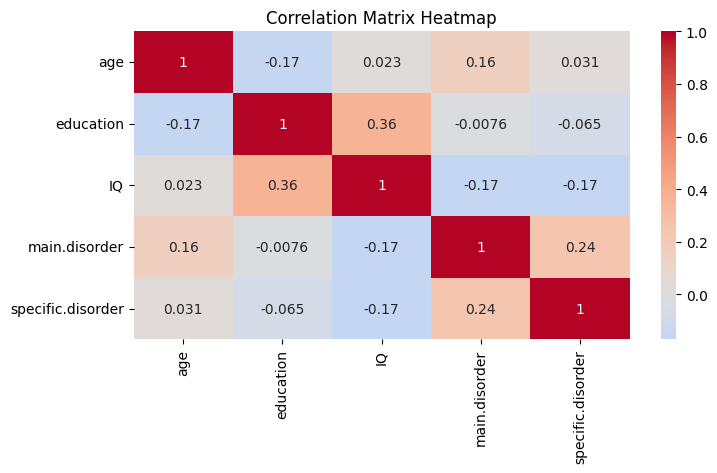

In [29]:
corr_matrix = input.iloc[:,np.r_[2:7]].corr()
display(corr_matrix)
plt.figure(figsize=(8, 4))  # Set the size of the plot
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [30]:
from statsmodels.stats.multitest import multipletests
from scipy.stats import pearsonr
import networkx as nx

data=input.copy()
data = data.iloc[:, np.r_[2:6]]
#Calculate correlation matrix and p-values
correlations = data.corr()
p_values = np.zeros_like(correlations)

for i in range(data.shape[1]):
    for j in range(data.shape[1]):
        if i != j:
            _, p_values[i, j] = pearsonr(data.iloc[:, i], data.iloc[:, j])

# Apply Benjamini-Hochberg correction for multiple comparisons
p_values_flat = p_values.flatten()
_, corrected_p_values_flat, _, _ = multipletests(p_values_flat, method='fdr_bh')
corrected_p_values = corrected_p_values_flat.reshape(p_values.shape)

# Apply thresholds (r >= 0.15 and p < 0.05)
significant_edges = np.where((np.abs(correlations) >= 0.15) & (corrected_p_values < 0.05), correlations, 0)

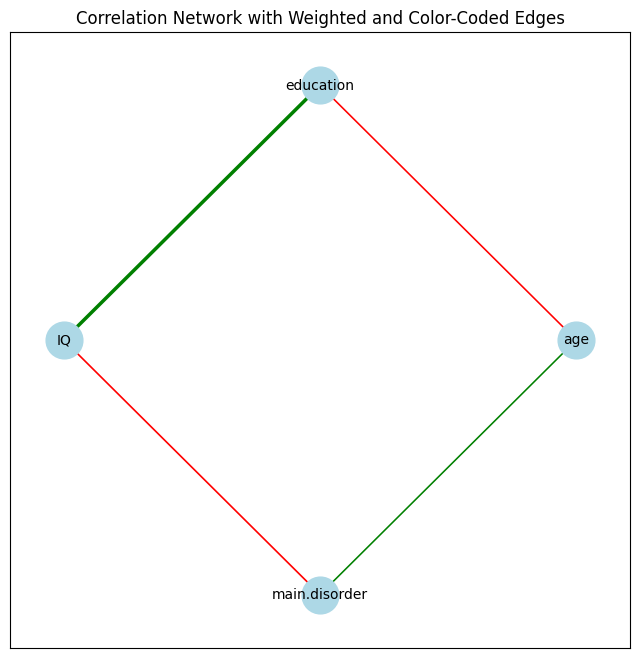

In [31]:
# Create an undirected graph
G = nx.Graph()

# Add nodes (symptoms)
for col in data.columns:
    G.add_node(col)


# Add edges for significant correlations with edge weights
for i in range(len(data.columns)):
    for j in range(i + 1, len(data.columns)):  # Avoid duplicate edges
        if significant_edges[i, j] != 0:
            # Determine edge color based on the sign of correlation
            color = 'green' if significant_edges[i, j] > 0 else 'red'
            G.add_edge(data.columns[i], data.columns[j], weight=significant_edges[i, j], color=color)

# Extract edges and colors
edges = G.edges(data=True)
weights = [d['weight'] for (u, v, d) in edges]
colors = [d['color'] for (u, v, d) in edges]


# Normalize weights for edge width
norm_weights = [abs(w) for w in weights]

# ciruclar layout for easy visualization
pos = nx.circular_layout(G)

# Plot the graph
plt.figure(figsize=(8, 8))

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=700)

# Draw edges with color coding based on weights
nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color=colors, width=[w*7 for w in norm_weights])

# Draw labels
nx.draw_networkx_labels(G, pos,font_size=10, font_color="black")

plt.title('Correlation Network with Weighted and Color-Coded Edges')

# Show the plot
plt.show()

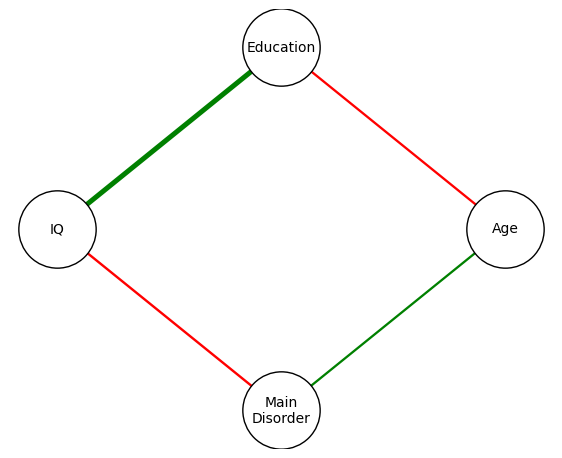

In [32]:
# Original node names
node_names = {
    'age': 'Age',
    'main.disorder': 'Main\nDisorder',
    'education': 'Education',
    'IQ': 'IQ'
}



# Rename nodes in the graph
G = nx.relabel_nodes(G, node_names)

# Extract edges and colors again after renaming nodes
edges = G.edges(data=True)
weights = [d['weight'] for (u, v, d) in edges]
colors = [d['color'] for (u, v, d) in edges]

# Normalize weights for edge width
norm_weights = [abs(w) for w in weights]

# Circular layout for easy visualization
pos = nx.circular_layout(G)

# Plot the graph
plt.figure(figsize=(7, 5.7))

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_color='white', node_size=3100,edgecolors='black')

# Draw edges with color coding based on weights
nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color=colors, width=[w*10 for w in norm_weights])

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=10, font_color="black")

plt.axis('off')

#Save the figure
plt.savefig('content/Correlation Network with Weighted and Color-Coded Edges-3.png', dpi=500, bbox_inches='tight')
plt.savefig('content/Correlation Network with Weighted and Color-Coded Edges-3.pdf', dpi=500, bbox_inches='tight')
# Show the plot
plt.show()


In [33]:
# Identify all maximal cliques
cliques = list(find_cliques(G))

# Find the largest maximal clique (i.e., the maximum clique)
maximum_clique = max(cliques, key=len)

print("Maximal Cliques: ", cliques)
print("Maximum Clique: ", maximum_clique)

Maximal Cliques:  [['Age', 'Main\nDisorder'], ['Age', 'Education'], ['IQ', 'Main\nDisorder'], ['IQ', 'Education']]
Maximum Clique:  ['Age', 'Main\nDisorder']


In [34]:
# Calculate correlation matrix
correlations = data.corr()

# Calculate p-values for each correlation
p_values = np.zeros_like(correlations)
for i in range(data.shape[1]):
    for j in range(data.shape[1]):
        if i != j:
            _, p_values[i, j] = pearsonr(data.iloc[:, i], data.iloc[:, j])

# Apply Benjamini-Hochberg correction
p_values_flat = p_values.flatten()
_, corrected_p_values_flat, _, _ = multipletests(p_values_flat, method='fdr_bh')
corrected_p_values = corrected_p_values_flat.reshape(p_values.shape)

# Create a matrix for storing the correlation coefficients and significance asterisks
formatted_matrix = pd.DataFrame(index=correlations.index, columns=correlations.columns)

# Apply thresholds and add stars based on significance levels
for i in range(data.shape[1]):
    for j in range(i + 1):
        corr_value = correlations.iloc[i, j]
        if corrected_p_values[i, j] < 0.001:
            star = '***'
        elif corrected_p_values[i, j] < 0.01:
            star = '**'
        elif corrected_p_values[i, j] < 0.05:
            star = '*'
        else:
            star = ''
        formatted_matrix.iloc[i, j] = f"{corr_value:.2f}{star}"
        formatted_matrix.iloc[j, i] = ''  # Set upper triangle to empty

# Convert the formatted matrix to a LaTeX table format
latex_table = formatted_matrix.to_latex()

# Display the formatted correlation matrix
print("Formatted Correlation Matrix:\n")
print(formatted_matrix)

# Display the LaTeX table
print("\nLaTeX Table:\n")
print(latex_table)

Formatted Correlation Matrix:

                    age education        IQ main.disorder
age                                                      
education      -0.17***                                  
IQ                 0.02   0.36***                        
main.disorder   0.16***     -0.01  -0.17***              

LaTeX Table:

\begin{tabular}{lllll}
\toprule
 & age & education & IQ & main.disorder \\
\midrule
age &  &  &  &  \\
education & -0.17*** &  &  &  \\
IQ & 0.02 & 0.36*** &  &  \\
main.disorder & 0.16*** & -0.01 & -0.17*** &  \\
\bottomrule
\end{tabular}



In [35]:
# import networkx as nx
# import matplotlib.pyplot as plt
# from scipy.stats import pearsonr
# from statsmodels.stats.multitest import multipletests
# import numpy as np

# # Define thresholds
# r_threshold = 0.15
# p_threshold = 0.08

# # Define disorder mappings
# disorder_mappings = {
#     'Addictive disorder': 0,
#     'Anxiety disorder': 1,
#     'Healthy control': 2,
#     'Mood disorder': 3,
#     'Obsessive compulsive disorder': 4,
#     'Schizophrenia': 5,
#     'Trauma and stress related disorder': 6
# }

# # Loop through each disorder and calculate the correlation network
# for disorder_name, disorder_code in disorder_mappings.items():
#     # Filter the dataset for the current disorder
#     filtered_data = input_copy[input_copy['main.disorder'] == disorder_code]
#     filtered_data = filtered_data.drop(columns=['main.disorder'])

#     # Calculate the correlation matrix and p-values
#     correlations = filtered_data.corr()
#     p_values = np.zeros_like(correlations)

#     for i in range(filtered_data.shape[1]):
#         for j in range(filtered_data.shape[1]):
#             if i != j:
#                 _, p_values[i, j] = pearsonr(filtered_data.iloc[:, i], filtered_data.iloc[:, j])

#     # Apply Benjamini-Hochberg correction
#     p_values_flat = p_values.flatten()
#     _, corrected_p_values_flat, _, _ = multipletests(p_values_flat, method='fdr_bh')
#     corrected_p_values = corrected_p_values_flat.reshape(p_values.shape)

#     # Threshold for significant correlations
#     significant_edges = np.where((np.abs(correlations) >= r_threshold) & (corrected_p_values < p_threshold), correlations, 0)

#     # Build the network
#     G = nx.Graph()
#     for i in range(significant_edges.shape[0]):
#         for j in range(i+1, significant_edges.shape[1]):
#             if significant_edges[i, j] != 0:
#                 G.add_edge(filtered_data.columns[i], filtered_data.columns[j], weight=significant_edges[i, j])

#     # Identify cliques
#     cliques = list(nx.find_cliques(G))
#     maximum_clique = max(cliques, key=len)

#     # Visualize the network
#     plt.figure(figsize=(8, 8))
#     pos = nx.circular_layout(G)
#     edges = G.edges(data=True)
#     weights = [d['weight'] for (u, v, d) in edges]
#     norm_weights = [abs(w) for w in weights]

#     nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=700)
#     nx.draw_networkx_edges(G, pos, edgelist=edges, width=[w*7 for w in norm_weights])
#     nx.draw_networkx_labels(G, pos, font_size=10, font_color="black")

#     plt.title(f'Correlation Network for {disorder_name}')
#     plt.axis('off')
#     plt.show()

#     print(f"Maximal Cliques for {disorder_name}: ", cliques)
#     print(f"Maximum Clique for {disorder_name}: ", maximum_clique)
#     print("\n" + "="*50 + "\n")


# **EEG Related Analysis**

[0.3310085  0.09582781 0.05242505 0.04328422 0.0355981  0.0285465
 0.02296505 0.021356   0.01963511 0.01796189]


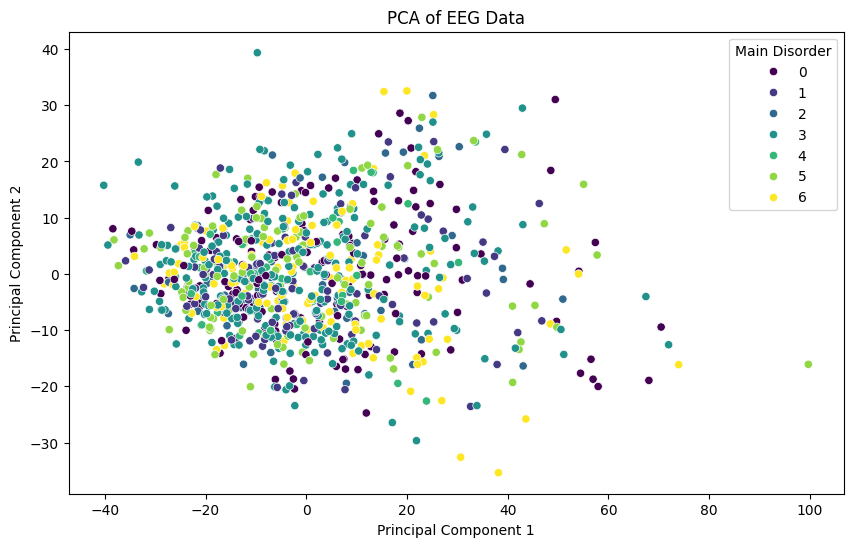

In [36]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Select EEG features
eeg_features = input.columns[7:1148]  # Assuming EEG features start from the 11th column
scaler = StandardScaler()
#eeg_features = input[eeg_features].select_dtypes(include=[float, int]).columns
scaled_data = scaler.fit_transform(input[eeg_features])

# Perform PCA
pca = PCA(n_components=10)
principal_components = pca.fit_transform(scaled_data)

# Create a DataFrame with principal components
pca_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(10)])
pca_df['Main Disorder'] = input['main.disorder']
print(pca.explained_variance_ratio_)

# Plot the principal components
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Main Disorder', data=pca_df, palette='viridis')
plt.title('PCA of EEG Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Main Disorder')
plt.show()

C:\Users\User\AppData\Roaming\Python\Python312\site-packages\scipy\signal\_spectral_py.py:2017: UserWarning: nperseg = 1024 is greater than input length  = 178, using nperseg = 178
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\User\AppData\Roaming\Python\Python312\site-packages\scipy\signal\_spectral_py.py:2017: UserWarning: nperseg = 1024 is greater than input length  = 123, using nperseg = 123
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\User\AppData\Roaming\Python\Python312\site-packages\scipy\signal\_spectral_py.py:2017: UserWarning: nperseg = 1024 is greater than input length  = 262, using nperseg = 262
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\User\AppData\Roaming\Python\Python312\site-packages\scipy\signal\_spectral_py.py:2017: UserWarning: nperseg = 1024 is greater than input length  = 93, using nperseg = 93
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\User\AppData\

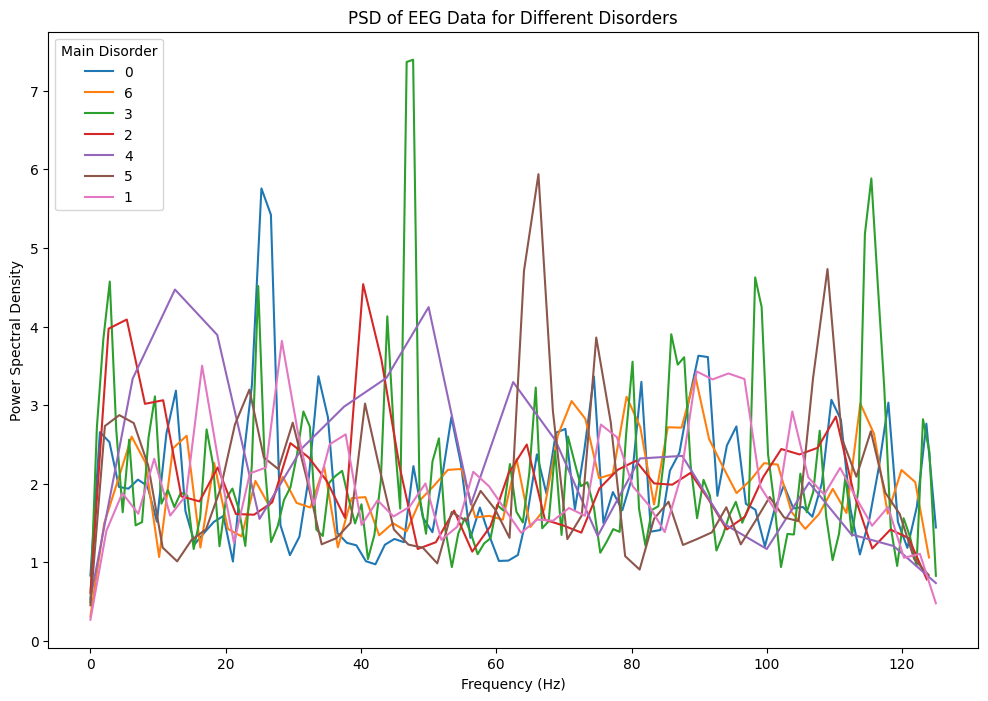

In [37]:
import numpy as np
from scipy.signal import welch
import matplotlib.pyplot as plt

# Define a function to calculate PSD
def calculate_psd(data, fs=250):
    freqs, psd = welch(data, fs=fs, nperseg=1024)
    return freqs, psd

# Plot PSD for different disorders
plt.figure(figsize=(12, 8))

for disorder in input['main.disorder'].unique():
    disorder_indices = input['main.disorder'] == disorder
    disorder_data = input.loc[disorder_indices, input.columns[7:1148]].values.T  # Transpose for channel-wise PSD

    # Calculate average PSD across all channels for this disorder
    psd_list = []
    for channel_data in disorder_data:
        freqs, psd = calculate_psd(channel_data)
        psd_list.append(psd)

    mean_psd = np.mean(psd_list, axis=0)
    plt.plot(freqs, mean_psd, label=disorder)

plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')
plt.title('PSD of EEG Data for Different Disorders')
plt.legend(title='Main Disorder')
plt.show()


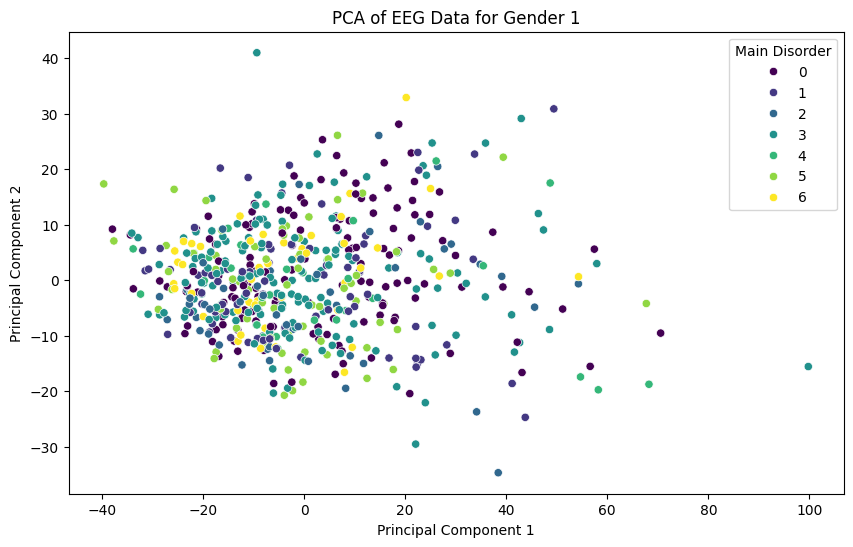

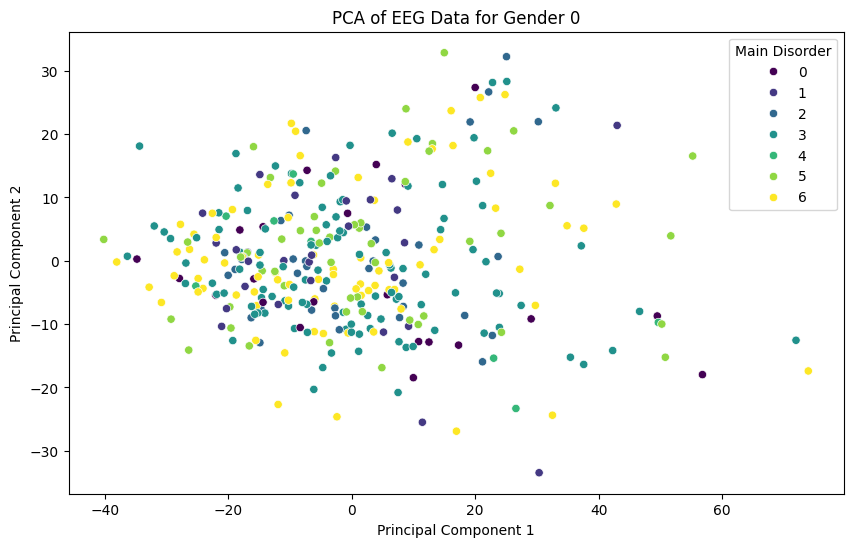

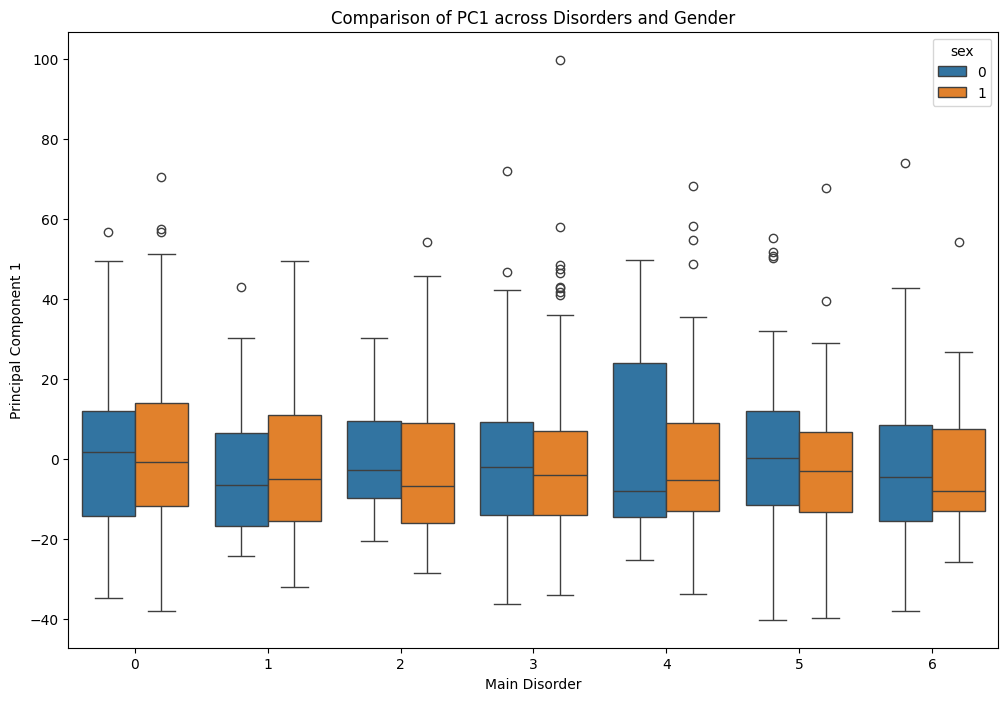

In [38]:
# Function to perform PCA and create a DataFrame with principal components
def perform_pca(data, n_components=2):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)
    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(scaled_data)
    return pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(n_components)])

# Group data by a demographic factor, e.g., gender
for gender in input['sex'].unique():
    gender_data = input[input['sex'] == gender]
    gender_eeg_data = gender_data.iloc[:, 7:1148].values

    # Perform PCA on the subgroup
    pca_df = perform_pca(gender_eeg_data)
    pca_df['Main_Disorder'] = gender_data['main.disorder'].values  # Ensure this is added correctly
    pca_df['sex'] = gender  # Add the sex information to the DataFrame

    # Plot PCA for the subgroup
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='PC1', y='PC2', hue='Main_Disorder', data=pca_df, palette='viridis')
    plt.title(f'PCA of EEG Data for Gender {gender}')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(title='Main Disorder')
    plt.show()

# Combine all PCA results for the box plot
combined_pca_df = pd.concat([perform_pca(input[input['sex'] == gender].iloc[:, 7:1148].values).assign(Main_Disorder=input[input['sex'] == gender]['main.disorder'].values, sex=gender) for gender in input['sex'].unique()])

# Box plot to compare EEG feature (e.g., a specific principal component) across subgroups
plt.figure(figsize=(12, 8))
sns.boxplot(x='Main_Disorder', y='PC1', hue='sex', data=combined_pca_df)
plt.title('Comparison of PC1 across Disorders and Gender')
plt.xlabel('Main Disorder')
plt.ylabel('Principal Component 1')
plt.show()

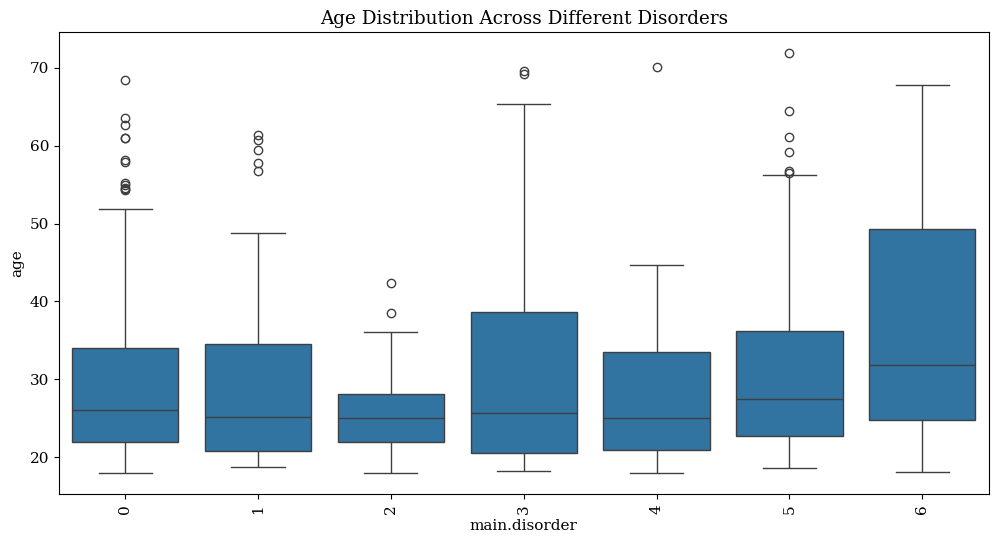

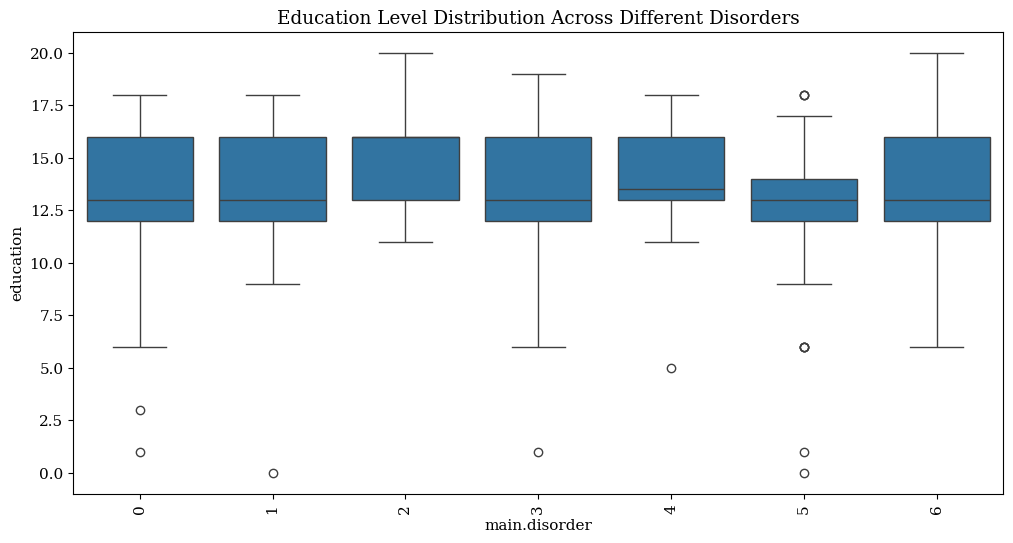

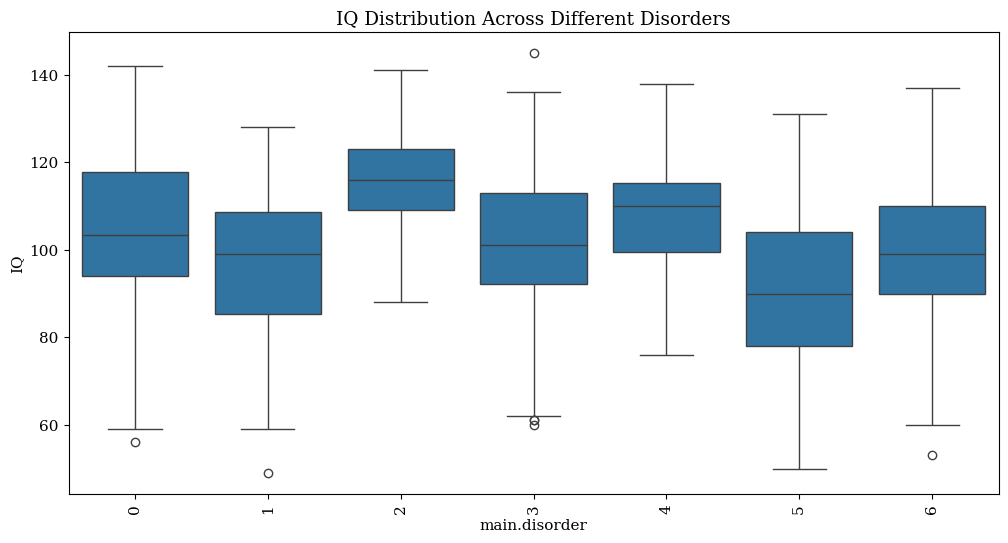

In [39]:
plt.rc('font', family='serif', size=11)
# Assuming df is your DataFrame containing the dataset
plt.figure(figsize=(12, 6))
sns.boxplot(x='main.disorder', y='age', data=input)
plt.title('Age Distribution Across Different Disorders')
plt.xticks(rotation=90)
plt.savefig('content/Age Distribution Across Different Disorders.png', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='main.disorder', y='education', data=input)
plt.title('Education Level Distribution Across Different Disorders')
plt.xticks(rotation=90)
plt.savefig('content/Education Level Distribution Across Different Disorders.png', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='main.disorder', y='IQ', data=input)
plt.title('IQ Distribution Across Different Disorders')
plt.xticks(rotation=90)
plt.savefig('content/IQ Distribution Across Disorders.png', dpi=300, bbox_inches='tight')
plt.show()

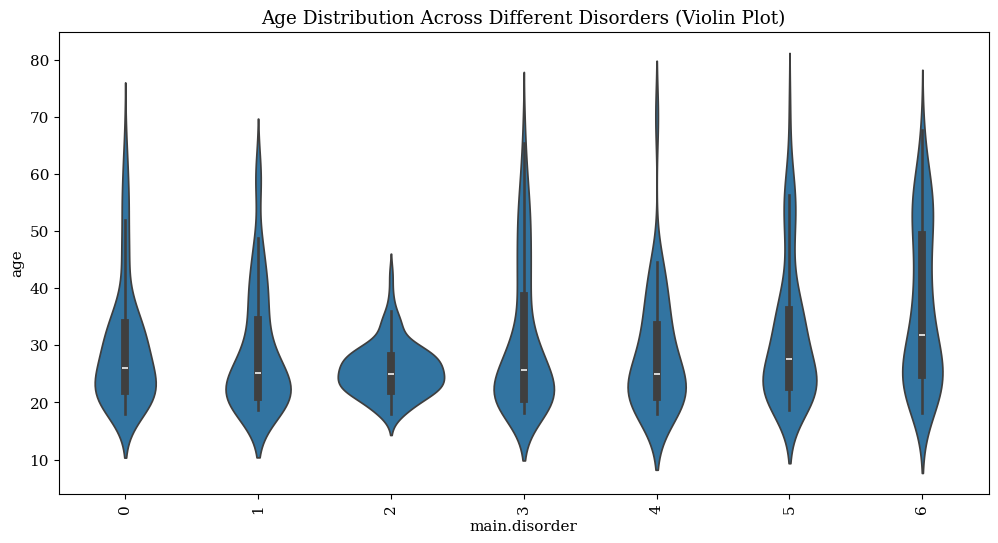

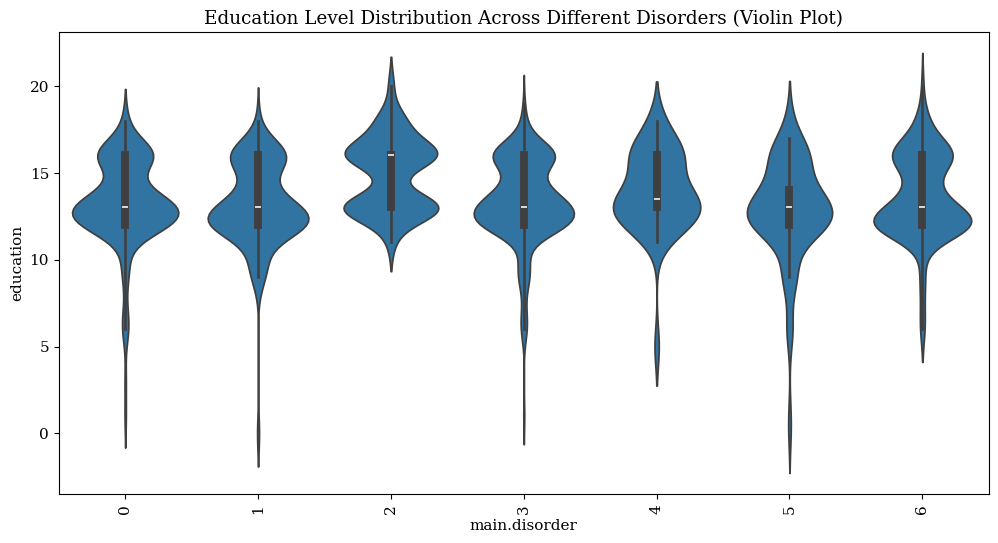

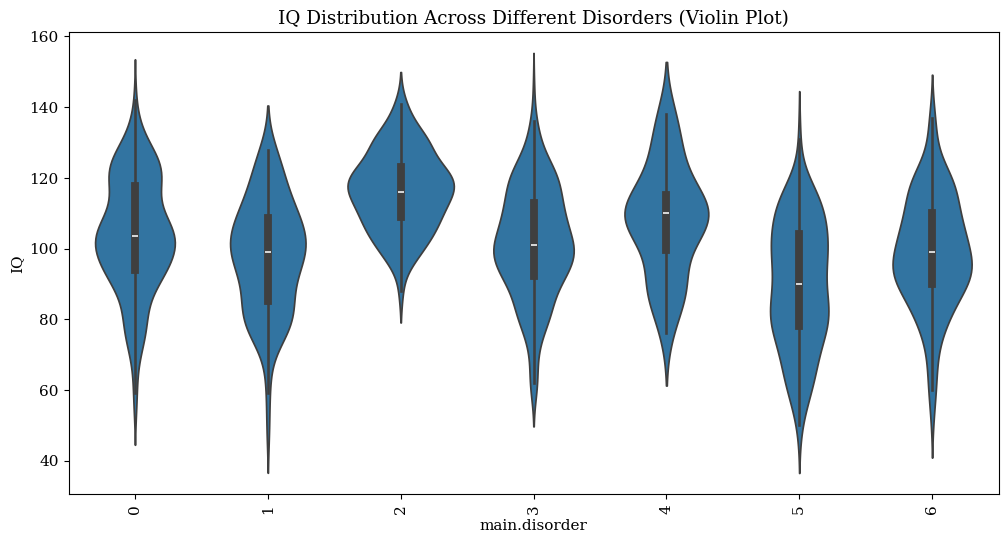

In [40]:
plt.figure(figsize=(12, 6))
sns.violinplot(x='main.disorder', y='age', data=input)
plt.title('Age Distribution Across Different Disorders (Violin Plot)')
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(12, 6))
sns.violinplot(x='main.disorder', y='education', data=input)
plt.title('Education Level Distribution Across Different Disorders (Violin Plot)')
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(12, 6))
sns.violinplot(x='main.disorder', y='IQ', data=input)
plt.title('IQ Distribution Across Different Disorders (Violin Plot)')
plt.xticks(rotation=90)
plt.show()

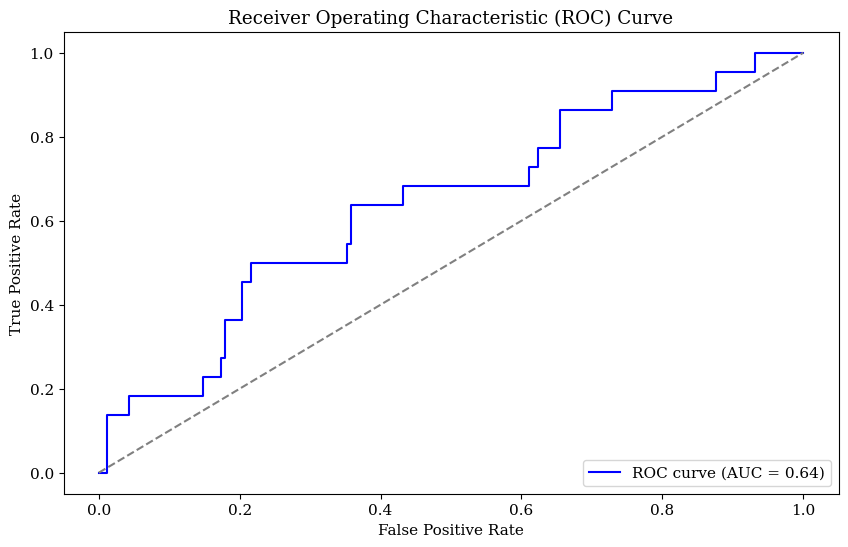

AUC: 0.64


In [41]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Load your data (assuming 'input' is your DataFrame)
# input = pd.read_csv('your_data.csv')

# Extract features and target
# Assuming 'main.disorder' is the target variable and we are predicting a specific disorder, say 'Schizophrenia' (encoded as 5)
target_disorder = 10
input['target'] = (input['specific.disorder'] == target_disorder).astype(int)

# Select demographic and EEG features
demographic_features = ['age', 'education', 'IQ', 'sex']  # Add more demographic features if available
eeg_features = input.columns[7:1148]  # Assuming EEG features start from the 8th column

# Combine features
features = demographic_features + list(eeg_features)
X = input[features]
y = input['target']

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train logistic regression model
model = LogisticRegression(max_iter=10000)
model.fit(X_train, y_train)

# Predict probabilities on the test set
y_probs = model.predict_proba(X_test)[:, 1]

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc = roc_auc_score(y_test, y_probs)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Print the AUC value
print(f'AUC: {auc:.2f}')


In [42]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

# Initialize GridSearchCV
grid_search = GridSearchCV(LogisticRegression(max_iter=10000), param_grid, cv=5, scoring='roc_auc')

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_auc = grid_search.best_score_

print(f'Best Parameters: {best_params}')
print(f'Best AUC: {best_auc:.2f}')


Best Parameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Best AUC: 0.74


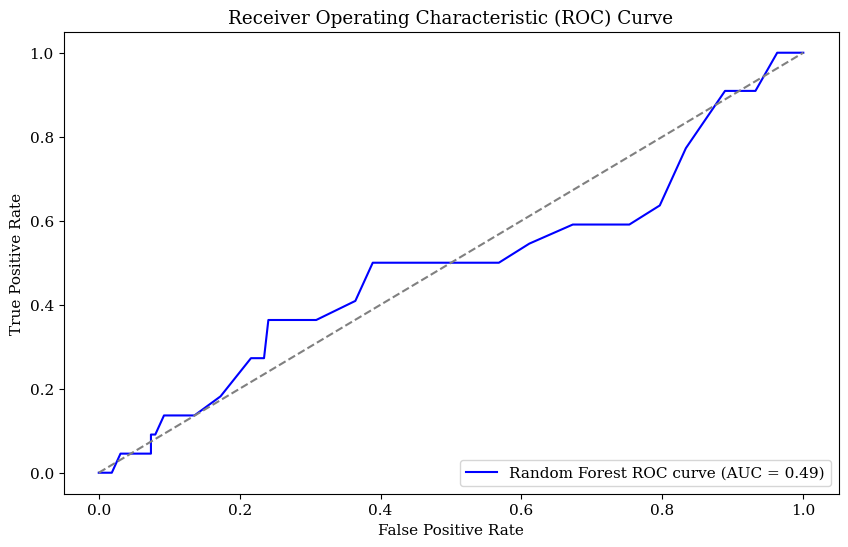

Random Forest AUC: 0.49


In [43]:
from sklearn.ensemble import RandomForestClassifier

# Initialize Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Fit the model
rf_model.fit(X_train, y_train)

# Predict probabilities
y_rf_probs = rf_model.predict_proba(X_test)[:, 1]

# Calculate ROC curve and AUC
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, y_rf_probs)
rf_auc = roc_auc_score(y_test, y_rf_probs)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(rf_fpr, rf_tpr, color='blue', label=f'Random Forest ROC curve (AUC = {rf_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Print the AUC value
print(f'Random Forest AUC: {rf_auc:.2f}')


Logistic Regression AUC: 0.59
Random Forest AUC: 0.70


C:\Users\User\AppData\Local\Temp\ipykernel_21544\2934194355.py:68: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='lower right')


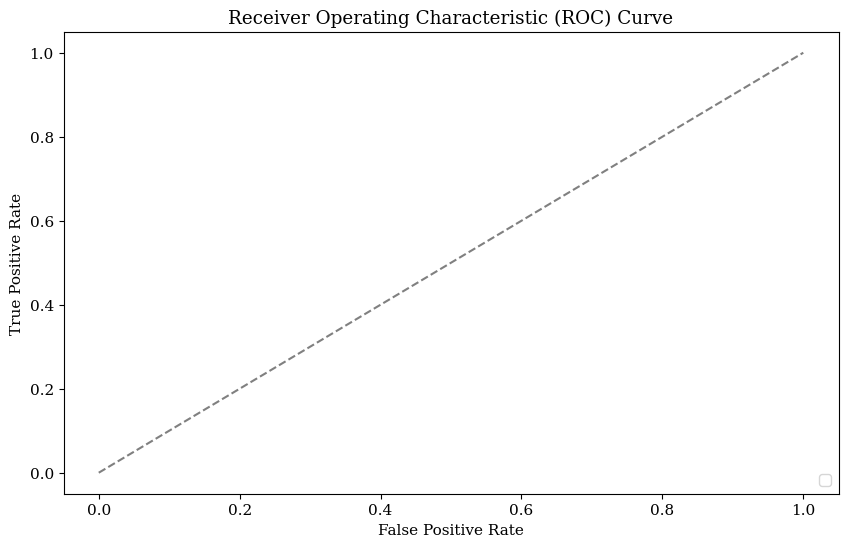

In [44]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

target_disorder = 5
input['target'] = (input['main.disorder'] == target_disorder).astype(int)

# Assuming 'input' is your DataFrame
# Demographic features
demographic_features = ['age', 'sex', 'education', 'IQ']

# EEG features
eeg_features = input.columns[20:1148]  # Adjust based on your column indices

# Select features
features = demographic_features + list(eeg_features)
x=input[features]
y = input['main.disorder']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Logistic Regression
logreg = LogisticRegression(max_iter=10000)
logreg.fit(X_train, y_train)
y_logreg_probs = logreg.predict_proba(X_test)

# Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_rf_probs = rf.predict_proba(X_test)

# Calculate ROC AUC for Logistic Regression using 'ovr' strategy
logreg_auc = roc_auc_score(y_test, y_logreg_probs, multi_class='ovr')
print(f'Logistic Regression AUC: {logreg_auc:.2f}')

# Calculate ROC AUC for Random Forest using 'ovr' strategy
rf_auc = roc_auc_score(y_test, y_rf_probs, multi_class='ovr')
print(f'Random Forest AUC: {rf_auc:.2f}')

# Compute ROC curve for each class and plot
plt.figure(figsize=(10, 6))

# Logistic Regression ROC curves
for i in range(len(logreg.classes_)):
    # Handle cases where predictions are 1D (single probability)
    if y_logreg_probs[:, i].ndim == 1:
        fpr, tpr, _ = roc_curve(y_test, y_logreg_probs[:, i], pos_label=logreg.classes_[i])
    else:
        fpr, tpr, _ = roc_curve(y_test, y_logreg_probs[:, i][:, 1], pos_label=logreg.classes_[i])  # Access second column if 2D

    #plt.plot(fpr, tpr, label=f'Logistic Regression class {logreg.classes_[i]} (AUC = {roc_auc_score(y_test, y_logreg_probs[:, i], multi_class="ovr"):.2f})')


# Random Forest ROC curves
for i in range(len(rf.classes_)):
    fpr, tpr, _ = roc_curve(y_test, y_rf_probs[:, i], pos_label=rf.classes_[i])
    #plt.plot(fpr, tpr, label=f'Random Forest class {rf.classes_[i]} (AUC = {roc_auc_score(y_test, y_rf_probs[:, i], multi_class="ovr"):.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()




In [45]:
# Assuming `data` is your DataFrame
descriptive_stats = input.groupby('main.disorder')[['age', 'education', 'IQ', 'sex']].describe()
print(descriptive_stats)

                 age                                                         \
               count       mean        std    min      25%     50%      75%   
main.disorder                                                                 
0              178.0  29.732865  10.801912  18.00  22.0000  26.070  34.0000   
1              106.0  28.964623  10.602514  18.72  20.8775  25.170  34.5100   
2               93.0  25.772581   4.586488  18.00  22.0000  25.050  28.1500   
3              262.0  30.805496  12.712083  18.19  20.5850  25.715  38.6200   
4               40.0  28.397500  10.240401  18.00  21.0000  25.005  33.5025   
5              117.0  31.729487  12.100694  18.69  22.7800  27.550  36.2700   
6              123.0  36.356341  13.790563  18.18  24.8450  31.900  49.3250   

                     education                                               \
                 max     count       mean       std   min   25%   50%   75%   
main.disorder                                      

In [46]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# ANOVA for sex
model_IQ = ols('sex ~ C(Q("main.disorder"))', data=input).fit()
anova_table_IQ = sm.stats.anova_lm(model_IQ, typ=2)
print("ANOVA for sex:\n", anova_table_IQ)

# ANOVA for age
model_age = ols('age ~ C(Q("main.disorder"))', data=input).fit()
anova_table_age = sm.stats.anova_lm(model_age, typ=2)
print("ANOVA for Age:\n", anova_table_age)

# ANOVA for education
model_education = ols('education ~ C(Q("main.disorder"))', data=input).fit()
anova_table_education = sm.stats.anova_lm(model_education, typ=2)
print("ANOVA for Education:\n", anova_table_education)

# ANOVA for IQ
model_IQ = ols('IQ ~ C(Q("main.disorder"))', data=input).fit()
anova_table_IQ = sm.stats.anova_lm(model_IQ, typ=2)
print("ANOVA for IQ:\n", anova_table_IQ)

ANOVA for sex:
                            sum_sq     df          F        PR(>F)
C(Q("main.disorder"))   23.769609    6.0  19.077557  5.178460e-21
Residual               189.383818  912.0        NaN           NaN
ANOVA for Age:
                               sum_sq     df         F        PR(>F)
C(Q("main.disorder"))    7013.700943    6.0  8.821878  2.281376e-09
Residual               120845.308913  912.0       NaN           NaN
ANOVA for Education:
                             sum_sq     df         F        PR(>F)
C(Q("main.disorder"))   275.988141    6.0  7.330265  1.141334e-07
Residual               5722.875841  912.0       NaN           NaN
ANOVA for IQ:
                               sum_sq     df          F        PR(>F)
C(Q("main.disorder"))   41852.442891    6.0  28.346351  3.617776e-31
Residual               224422.934693  912.0        NaN           NaN


In [47]:
# Correlation matrix
correlation_matrix = input[['age', 'education', 'IQ']].corr()
print("Correlation Matrix:\n", correlation_matrix)

Correlation Matrix:
                 age  education        IQ
age        1.000000  -0.165761  0.023495
education -0.165761   1.000000  0.362670
IQ         0.023495   0.362670  1.000000


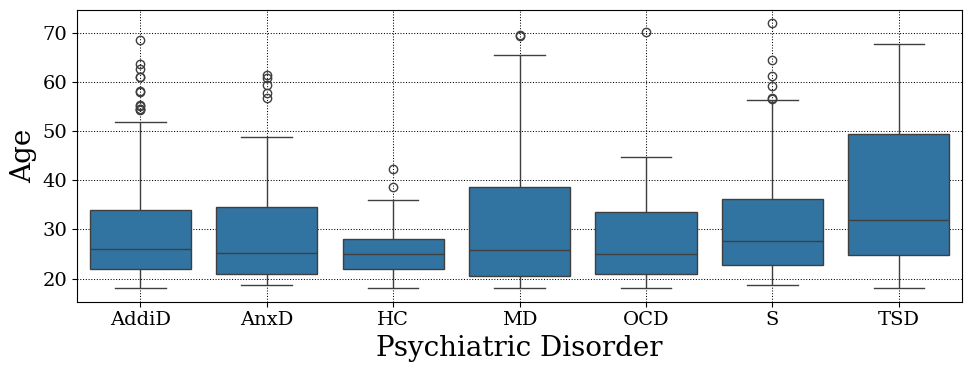

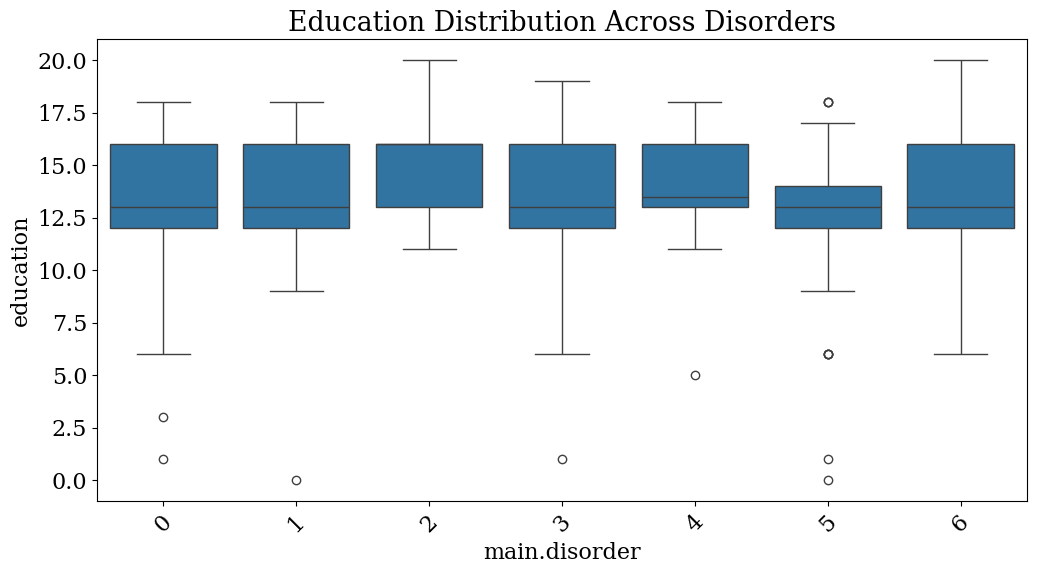

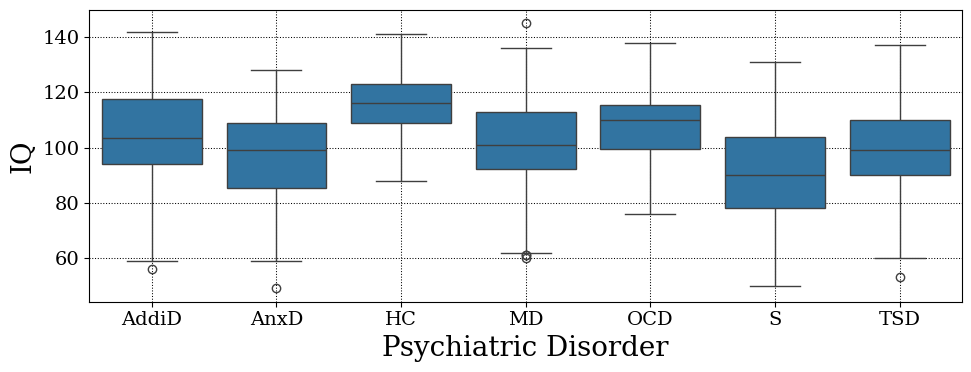

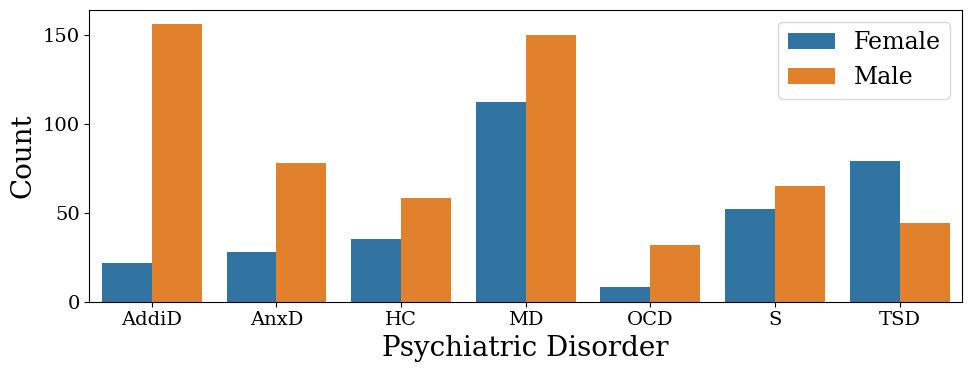

In [48]:
# Example: Creating a stacked bar plot using pandas
plt.style.use('default')  # Reset style to default
plt.rc('font', family='serif', size=16)

# Boxplot for age
plt.figure(figsize=(10, 4))
sns.boxplot(x='main.disorder', y='age', data=input)
plt.xlabel('Psychiatric Disorder',fontsize=20)
plt.ylabel('Age',fontsize=20)

# Add a grid with light dotted lines
plt.grid(True, linestyle=':', linewidth=0.75, color='black')
#plt.title('Age Distribution Across Disorders')
plt.setp(plt.gca().get_xticklabels(), fontsize=14, fontfamily='serif')
plt.setp(plt.gca().get_yticklabels(), fontsize=14, fontfamily='serif')
#plt.xticks(rotation=45, ha='right')
plt.xticks(ticks=[0, 1, 2, 3, 4, 5, 6], labels=['AddiD', 'AnxD', 'HC', 'MD', 'OCD', 'S', 'TSD'])
# Adjust layout to fit everything nicely
plt.tight_layout()
plt.savefig('content/Age Distribution Across Disorders.pdf', dpi=600, bbox_inches='tight')
plt.savefig('content/Age Distribution Across Disorders.png', dpi=600, bbox_inches='tight')
plt.show()

# Boxplot for education
plt.figure(figsize=(12, 6))
sns.boxplot(x='main.disorder', y='education', data=input)
plt.title('Education Distribution Across Disorders')
plt.xticks(rotation=45)
plt.show()

# Boxplot for IQ
plt.figure(figsize=(10, 4))
sns.boxplot(x='main.disorder', y='IQ', data=input)
plt.xlabel('Psychiatric Disorder',fontsize=20)
plt.ylabel('IQ',fontsize=20)
#plt.title('IQ Distribution Across Disorders')
# Add a grid with light dotted lines
plt.grid(True, linestyle=':', linewidth=0.75, color='black')
plt.setp(plt.gca().get_xticklabels(), fontsize=14, fontfamily='serif')
plt.setp(plt.gca().get_yticklabels(), fontsize=14, fontfamily='serif')
#plt.xticks(rotation=45, ha='right')
plt.xticks(ticks=[0, 1, 2, 3, 4, 5, 6], labels=['AddiD', 'AnxD', 'HC', 'MD', 'OCD', 'S', 'TSD'])
plt.tight_layout()
plt.savefig('content/IQ Distribution Across Disorders.pdf', dpi=600, bbox_inches='tight')
plt.savefig('content/IQ Distribution Across Disorders.png', dpi=600, bbox_inches='tight')
plt.show()

# Bar chart for sex
plt.figure(figsize=(10, 4))
sns.countplot(x='main.disorder', hue='sex', data=input)
plt.xlabel('Psychiatric Disorder', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.setp(plt.gca().get_xticklabels(), fontsize=14, fontfamily='serif')
plt.setp(plt.gca().get_yticklabels(), fontsize=14, fontfamily='serif')
legend = plt.legend(fontsize=17)
legend.get_texts()[0].set_text('Female')
legend.get_texts()[1].set_text('Male')
plt.xticks(ticks=[0, 1, 2, 3, 4, 5, 6], labels=['AddiD', 'AnxD', 'HC', 'MD', 'OCD', 'S', 'TSD'])
plt.tight_layout()
plt.savefig('content/Sex Distribution Across Disorder.pdf', dpi=300, bbox_inches='tight')
plt.show()

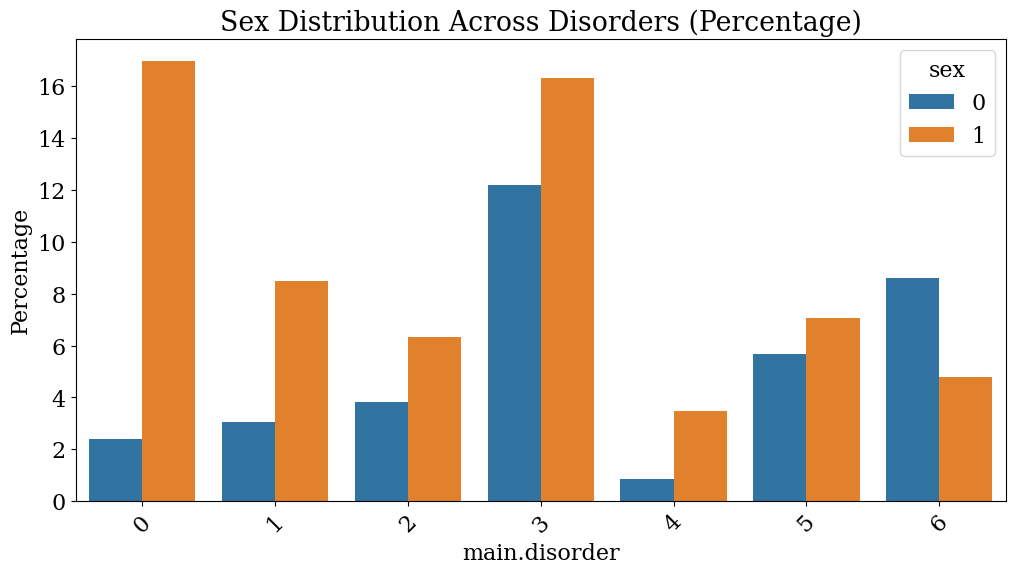

In [49]:
# Calculate percentages
data=input
data['percentage'] = data.groupby('main.disorder')['sex'].transform(lambda x: 100 * x.count() / len(data))

# Plot percentage bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x='main.disorder', y='percentage', hue='sex', data=data, estimator=lambda x: len(x) / len(data) * 100)
plt.title('Sex Distribution Across Disorders (Percentage)')
plt.xticks(rotation=45)
plt.ylabel('Percentage')
plt.show()

In [50]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Post-hoc test for sex
tukey_age = pairwise_tukeyhsd(endog=input['sex'], groups=input['main.disorder'], alpha=0.05)
print("Tukey HSD for Sex:\n", tukey_age)


# Post-hoc test for age
tukey_age = pairwise_tukeyhsd(endog=input['age'], groups=input['main.disorder'], alpha=0.05)
print("Tukey HSD for Age:\n", tukey_age)

# Post-hoc test for education
tukey_education = pairwise_tukeyhsd(endog=input['education'], groups=input['main.disorder'], alpha=0.05)
print("Tukey HSD for Education:\n", tukey_education)

# Post-hoc test for IQ
tukey_IQ = pairwise_tukeyhsd(endog=input['IQ'], groups=input['main.disorder'], alpha=0.05)
print("Tukey HSD for IQ:\n", tukey_IQ)


Tukey HSD for Sex:
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     0      1  -0.1406 0.1553 -0.3058  0.0246  False
     0      2  -0.2527 0.0003  -0.425 -0.0805   True
     0      3  -0.3039    0.0 -0.4347 -0.1731   True
     0      4  -0.0764 0.9626  -0.312  0.1592  False
     0      5  -0.3208    0.0 -0.4811 -0.1606   True
     0      6  -0.5187    0.0 -0.6766 -0.3608   True
     1      2  -0.1122  0.594 -0.3035  0.0791  False
     1      3  -0.1633 0.0313 -0.3183 -0.0083   True
     1      4   0.0642 0.9886 -0.1857   0.314  False
     1      5  -0.1803 0.0506 -0.3609  0.0003  False
     1      6  -0.3781    0.0 -0.5566 -0.1997   True
     2      3  -0.0511 0.9678 -0.2137  0.1114  False
     2      4   0.1763 0.3859 -0.0783   0.431  False
     2      5  -0.0681 0.9352 -0.2552   0.119  False
     2      6  -0.2659 0.0005  -0.451 -0.0809   True
     3      4   0.2275 0.0